<a href="https://colab.research.google.com/github/yasirabd/research-diagnostic-turbine/blob/main/Diagnostics_Turbine_Bearing_1_Cooling_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Create: 23 Desember 2021*<br>
*Last Update: 31 January 2022*<br>
*Author: Yasir Abdur Rohman*<br>
**Property of PT Indonesia Power & Lab Getaran & Diagnosis Mesin Undip**

---

## Problem Description

**Case:** ST Journal Bearing 1 - Cooling Loss

**Description:**

This fault indicates an abnormal change in the cooling of the supply oil to the bearings.  

Primary indicators are: 
- Journal Bearing Oil Outlet Temperature (Oil Return) is high; 
- and Bearing Metal Temperature is high.   

and 
- Priority 4 (lowest) is triggered when either Lube Oil Outlet Temperature is high or 
- Bearing Metal Temperature is high.  

The priority escalates depending on the severity of the change, and the number of sensors.  This fault triggers  Priority 2, 3 & 4.

**Input Tags:**
- LUBE_OIL_COOLER_OIL_OUTLET_TEMP
- GROSS_LOAD
- LUBE_OIL_COOLER_OIL_OUTLET_PRESS
- BRG_1_MTL_TEMP_1 
- AMBIENT_TEMP
- BRG_1_MTL_TEMP_2 
- BRG_1_MTL_TEMP_4 
- BRG_1_MTL_TEMP_3
- BRG_1_OIL_DRAIN_TEMP

**Expressions:**

```
if
    (ModelIndications(MECHANICAL,[SVH,SH,VH],[BRG_1_OIL_DRAIN_TEMP])>=1.0
    and
    ModelIndications(MECHANICAL,[SVH,SH,VH],[BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4])>=1.0)
then 
    Priority(2)
else if
    (ModelIndications(MECHANICAL,[SVH,SH,VH],[BRG_1_OIL_DRAIN_TEMP])>=1.0
    or 
        (ModelIndications(MECHANICAL,[VAR,H],[BRG_1_OIL_DRAIN_TEMP])>=1.0
        and
        ModelIndications(MECHANICAL,[VAR,H],[BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4])>=1.0))
then 
    Priority(3)
else if
    (ModelIndications(MECHANICAL,[VAR,H],[BRG_1_OIL_DRAIN_TEMP])>=1.0)
then 
    Priority(4)
else
    IsAssociated(MECHANICAL,[GROSS_LOAD,AMBIENT_TEMP,LUBE_OIL_COOLER_OIL_OUTLET_TEMP, LUBE_OIL_COOLER_OIL_OUTLET_PRESS])
```

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy.spatial import distance

from sklearn.metrics import mean_squared_error

# Dataset

In [2]:
path1 = "/content/drive/MyDrive/Prescriptive Maintenance/Data/Turbine Generator - SLA5/export_datasla5_01jan20-31mar20.csv"
path2 = "/content/drive/MyDrive/Prescriptive Maintenance/Data/Turbine Generator - SLA5/export_datasla5_01apr20-31jul20.csv"
path3 = "/content/drive/MyDrive/Prescriptive Maintenance/Data/Turbine Generator - SLA5/export_datasla5_01ags20-31des20.csv"
path4 = "/content/drive/MyDrive/Prescriptive Maintenance/Data/Turbine Generator - SLA5/export_datasla5_01jan21-31mar21.csv"
path5 = "/content/drive/MyDrive/Prescriptive Maintenance/Data/Turbine Generator - SLA5/export_datasla5_01apr21-31jul21.csv"
path6 = "/content/drive/MyDrive/Prescriptive Maintenance/Data/Turbine Generator - SLA5/export_datasla5_01ags21-31okt21.csv"


data1 = pd.read_csv(path1)
data2 = pd.read_csv(path2)
data3 = pd.read_csv(path3)
data4 = pd.read_csv(path4)
data5 = pd.read_csv(path5)
data6 = pd.read_csv(path6)

print(f'Data 1 shape: {data1.shape}')
print(f'Data 2 shape: {data2.shape}')
print(f'Data 3 shape: {data3.shape}')
print(f'Data 4 shape: {data4.shape}')
print(f'Data 5 shape: {data5.shape}')
print(f'Data 6 shape: {data6.shape}')

Data 1 shape: (131039, 85)
Data 2 shape: (175679, 85)
Data 3 shape: (220319, 85)
Data 4 shape: (129599, 85)
Data 5 shape: (175679, 85)
Data 6 shape: (132479, 85)


In [3]:
# slice data
cols = ['Generator Gross Capacity',
        'Turbine Lube Oil Cooler Outlet Temperature',
        # 'Turbine Bearing #01 Metal Temperature',
        'Turbine.Bearing 1 Metal Temperature',
        'Turbine.Bearing Oil Pressure',
        'Turbine.Bearing 1 Drain Oil Temperature']

data1 = data1[['date']+cols]
data2 = data2[['date']+cols]
data3 = data3[['date']+cols]
data4 = data4[['date']+cols]
data5 = data5[['date']+cols]
data6 = data6[['date']+cols]

# sort by index
data1 = data1.sort_values(by='date').reset_index(drop=True)
data2 = data2.sort_values(by='date').reset_index(drop=True)
data3 = data3.sort_values(by='date').reset_index(drop=True)
data4 = data4.sort_values(by='date').reset_index(drop=True)
data5 = data5.sort_values(by='date').reset_index(drop=True)
data6 = data6.sort_values(by='date').reset_index(drop=True)

# convert date to datetime
data1['date'] = pd.to_datetime(data1['date'])
data2['date'] = pd.to_datetime(data2['date'])
data3['date'] = pd.to_datetime(data3['date'])
data4['date'] = pd.to_datetime(data4['date'])
data5['date'] = pd.to_datetime(data5['date'])
data6['date'] = pd.to_datetime(data6['date'])

In [4]:
# handle missing with interpolation
# for col in cols:
#     data[col] = data[col].interpolate(method='linear')

# data.isnull().sum()

In [5]:
# missing value
data1.isnull().sum()/len(data1)*100

date                                          0.000000
Generator Gross Capacity                      7.376430
Turbine Lube Oil Cooler Outlet Temperature    7.376430
Turbine.Bearing 1 Metal Temperature           7.377193
Turbine.Bearing Oil Pressure                  7.376430
Turbine.Bearing 1 Drain Oil Temperature       7.379482
dtype: float64

In [6]:
# missing value
data2.isnull().sum()/len(data2)*100

date                                          0.000000
Generator Gross Capacity                      0.005692
Turbine Lube Oil Cooler Outlet Temperature    0.005692
Turbine.Bearing 1 Metal Temperature           0.005692
Turbine.Bearing Oil Pressure                  0.005692
Turbine.Bearing 1 Drain Oil Temperature       0.006261
dtype: float64

In [7]:
# missing value
data3.isnull().sum()/len(data3)*100

date                                          0.000000
Generator Gross Capacity                      0.053105
Turbine Lube Oil Cooler Outlet Temperature    0.096224
Turbine.Bearing 1 Metal Temperature           0.053559
Turbine.Bearing Oil Pressure                  0.125727
Turbine.Bearing 1 Drain Oil Temperature       0.056736
dtype: float64

In [8]:
# missing value
data4.isnull().sum()/len(data4)*100

date                                          0.000000
Generator Gross Capacity                      0.006944
Turbine Lube Oil Cooler Outlet Temperature    0.006944
Turbine.Bearing 1 Metal Temperature           0.006944
Turbine.Bearing Oil Pressure                  0.006944
Turbine.Bearing 1 Drain Oil Temperature       0.008488
dtype: float64

In [9]:
# missing value
data5.isnull().sum()/len(data5)*100

date                                           0.000000
Generator Gross Capacity                      23.555462
Turbine Lube Oil Cooler Outlet Temperature    25.166355
Turbine.Bearing 1 Metal Temperature           24.940374
Turbine.Bearing Oil Pressure                  22.792707
Turbine.Bearing 1 Drain Oil Temperature       25.161801
dtype: float64

In [10]:
# missing value
data6.isnull().sum()/len(data6)*100

date                                          0.000000
Generator Gross Capacity                      4.783400
Turbine Lube Oil Cooler Outlet Temperature    4.807554
Turbine.Bearing 1 Metal Temperature           4.790193
Turbine.Bearing Oil Pressure                  4.791703
Turbine.Bearing 1 Drain Oil Temperature       4.396168
dtype: float64

# Prognostic (Estimate)

## Threshold

In [11]:
# threshold
# val = [[433.969025, 610.248900],
#        [41.625633, 47.335740],
#        [75.298727, 92.167030],
#        [80.187670, 87.590470],
#        [1.467023, 1.512295],
#     #    [47.408993, 56.443672]]
#        [47.408993, 52]]

# new threshold from data january 2020 - march 2020
# val = [[433., 610.],
#        [41., 47.],
#     #    [80., 87.180405],
#        [83., 85.], # customize for fault
#        [1.48, 1.54],
#     #    [47., 55.]]
#        [50., 52.]] # customize for fault

# threshold from Indonesia Power
val = [[-5, 680],
       [0, 50],
       [0, 95],
       [0.75, 100],
       [0, 77]]
threshold = pd.DataFrame(val, columns=['Actual (Low)', 'Actual (High)'], index=list(data1)[1:])
threshold

,Actual (Low),Actual (High)
Generator Gross Capacity,-5.00,680
Turbine Lube Oil Cooler Outlet Temperature,0.00,50
Turbine.Bearing 1 Metal Temperature,0.00,95
Turbine.Bearing Oil Pressure,0.75,100
Turbine.Bearing 1 Drain Oil Temperature,0.00,77


## Infant Model
Create an infant model from data `January 2020` to `March 2020`

In [12]:
# create an infant model
two_weeks = pd.to_datetime('2020-01-01 00:00:00') + pd.DateOffset(days=15)

# filter data by date
filter = (data1['date'] >= '2020-01-01 00:00:00') & (data1['date'] < two_weeks)
data_slice = data1[filter].reset_index(drop=True)
data_slice.shape

(21600, 6)

In [13]:
# create state_matrix for an infant model
state_matrix = []
for i in range(len(data_slice)):

    temp = []
    for col in cols:
        actual = data_slice.loc[i,col]
        th_low = threshold.loc[col, 'Actual (Low)']
        th_high = threshold.loc[col, 'Actual (High)']

        if actual > th_low and actual < th_high:
            temp.append(actual)
        else:
            break

    if len(temp) == 5:
        state_matrix.append(np.array(temp))
    
    if len(state_matrix) == 400:
        state_matrix = np.array(state_matrix).T
        print(i)
        break

399


In [14]:
state_matrix.shape

(5, 400)

In [15]:
np.isnan(state_matrix).sum()

0

## VBM

In [16]:
def scipy_distance(vector1, vector2, dist='euclidean'):
    if dist == 'euclidean':
        return distance.euclidean(vector1, vector2)
    elif dist == 'braycurtis':
        return distance.braycurtis(vector1, vector2)
    elif dist == 'correlation':
        return distance.correlation(vector1, vector2)
    elif dist == 'canberra':
        return distance.canberra(vector1, vector2)
    elif dist == 'chebyshev':
        return distance.chebyshev(vector1, vector2)
    elif dist == 'cityblock':
        return distance.cityblock(vector1, vector2)
    elif dist == 'minkowski':
        return distance.minkowski(vector1, vector2)
    elif dist == 'sqeuclidean':
        return distance.sqeuclidean(vector1, vector2)
    elif dist == 'cosine':
        return distance.cosine(vector1, vector2)

# function to create a dynamic matrix 
def create_dynamic_matrix(matrix, current_actual):
    
    # get current actual
    # current_actual = matrix[:, -1]

    # calculate similarity
    sim_vec = []
    for i in range(matrix.shape[1]):
        sim = 1 - scipy_distance(current_actual, matrix[:, i], dist='canberra')
        sim_vec.append(sim)
    
    # sort the matrix
    n = 10
    top = np.sort(np.array(sim_vec).argsort()[::-1][:n])
    top_sim_vec = np.array(sim_vec)[top]

    # create dynamic matrix
    dynamic_matrix = matrix[:, top]

    # calculate weight
    weight = np.array([s/np.sum(top_sim_vec) for s in top_sim_vec])

    return dynamic_matrix, weight

def vbm(dynamic_matrix, weight):
    return np.dot(dynamic_matrix, weight.T)

# Diagnostic

## Analytic Tag Attributes

https://www.ge.com/digital/documentation/predix-apm/latest/smartsignal-expression-syntax.html

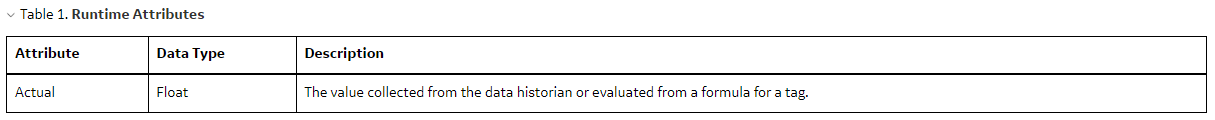

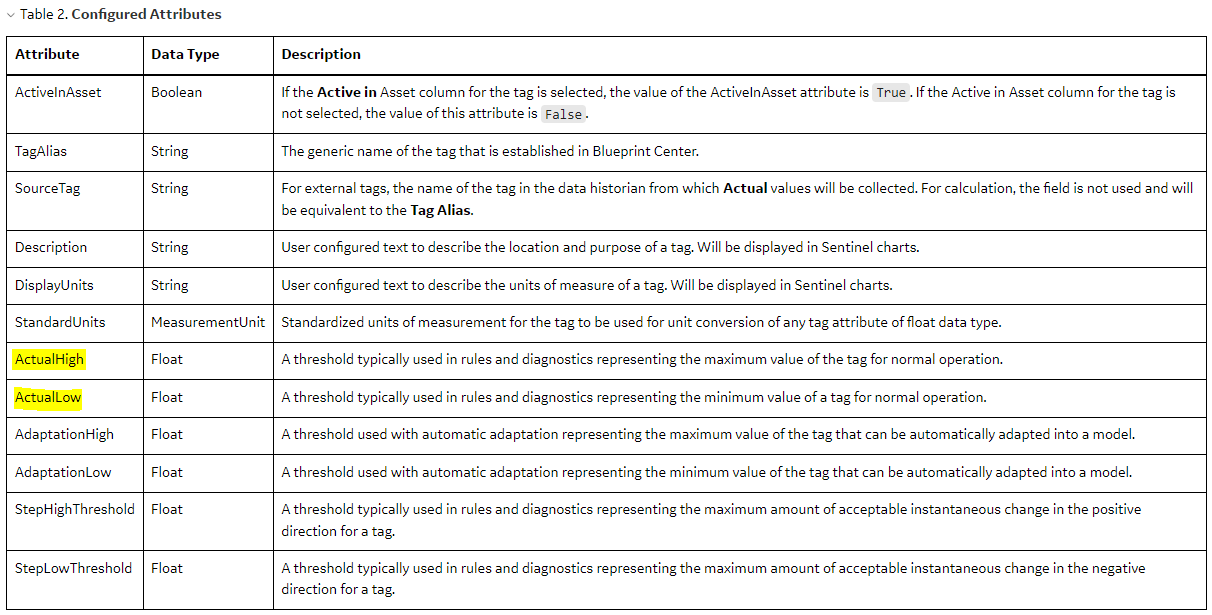

## Model Tag Attributes

https://www.ge.com/digital/documentation/predix-apm/latest/smartsignal-expression-syntax.html

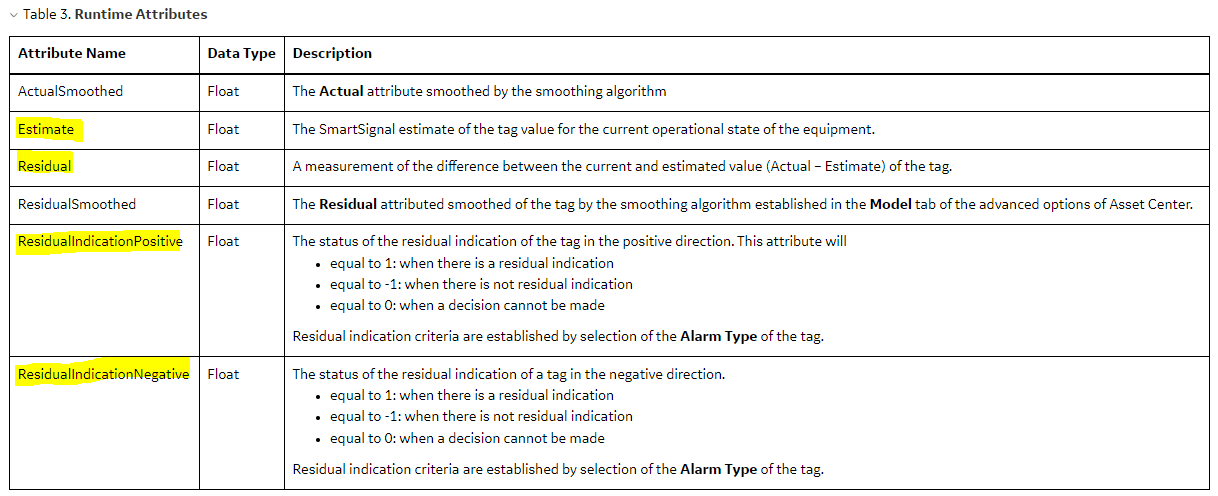

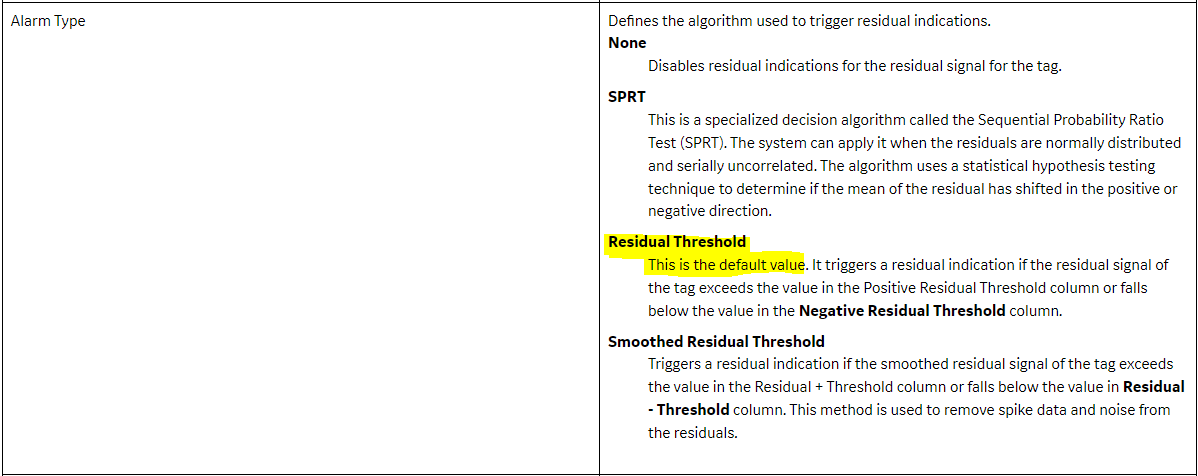

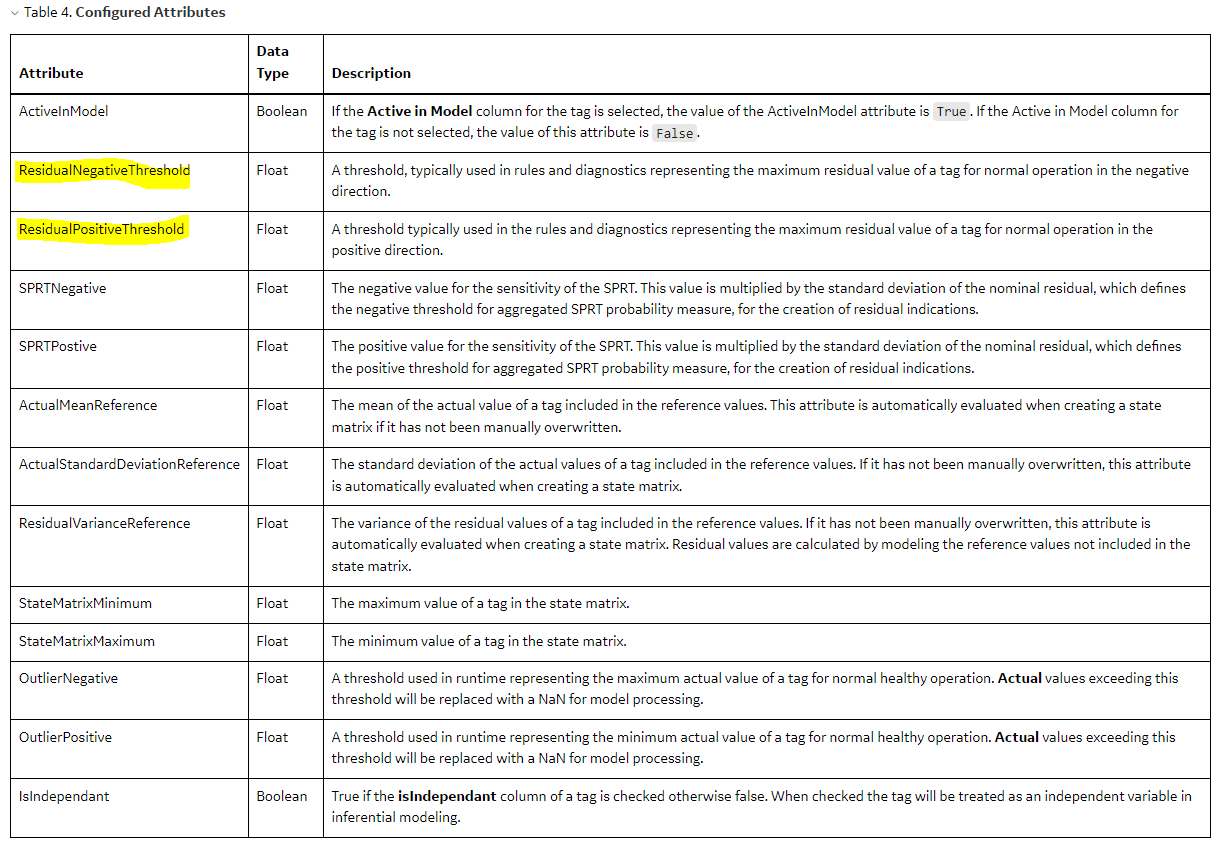

Analytic tag attributes needed for `ST Journal Bearing 1 - Cooling Loss`.

Runtime Attributes:
- `Actual`

Configured Attributes:
- `ActualHigh`
- `ActualLow`

Model tag attributes needed for `ST Journal Bearing 1 - Cooling Loss`.

Runtime Attributes:
- `Estimate`
- `Residual`
- `ResidualIndicationPositive`
- `ResidualIndicationNegative`

Configured Attributes:
- `ResidualNegativeThreshold`
- `ResidualPositiveThreshold`

> We choose `AlarmType` by default is `Residual Threshold`

We need to define all of the **Configured Attributes**.

## Define Configured Attributes

In [17]:
# analytic tag
analytic_configured = threshold.copy()
# rename columns name
analytic_configured = analytic_configured.rename(columns={'Actual (Low)':'ActualLow',
                                                          'Actual (High)':'ActualHigh'})
analytic_configured

,ActualLow,ActualHigh
Generator Gross Capacity,-5.00,680
Turbine Lube Oil Cooler Outlet Temperature,0.00,50
Turbine.Bearing 1 Metal Temperature,0.00,95
Turbine.Bearing Oil Pressure,0.75,100
Turbine.Bearing 1 Drain Oil Temperature,0.00,77


In [18]:
analytic_configured['ActualHigh'] - analytic_configured['ActualLow']

Generator Gross Capacity                      685.00
Turbine Lube Oil Cooler Outlet Temperature     50.00
Turbine.Bearing 1 Metal Temperature            95.00
Turbine.Bearing Oil Pressure                   99.25
Turbine.Bearing 1 Drain Oil Temperature        77.00
dtype: float64

In [19]:
# model tag

# use the difference between ActualHigh and ActualLow
values = [[-685., 685.],
          [-50., 50.],
          [-95., 95.],
          [-99.25, 99.25],
          [-77., 77.]] # customize for fault
model_configured = pd.DataFrame(data=values,
                                index=analytic_configured.index,
                                columns=['ResidualNegativeThreshold','ResidualPositiveThreshold'])
model_configured

,ResidualNegativeThreshold,ResidualPositiveThreshold
Generator Gross Capacity,-685.00,685.00
Turbine Lube Oil Cooler Outlet Temperature,-50.00,50.00
Turbine.Bearing 1 Metal Temperature,-95.00,95.00
Turbine.Bearing Oil Pressure,-99.25,99.25
Turbine.Bearing 1 Drain Oil Temperature,-77.00,77.00


## Process Runtime Attributes

In [20]:
N_TAG = 5

def estimate_sensors(actual, state_matrix, analytic_conf):
    """Estimate smart signal
    actual: sensor values
    state_matrix: state matrix
    analytic_conf: object analytic configured attributes
    """

    temp = []
    th = analytic_conf.values
    # CHECK IF WE NEED TO UPDATE THE STATE MATRIX
    for i in range(N_TAG):
        act = actual[i] 
        th_low = th[i][0]
        th_high = th[i][1]
        if act > th_low and act < th_high:
            temp.append(act)
        else:
            break
    # update state_matrix if all of the sensors are normal
    if len(temp) == N_TAG:  # 5 sensors/tags
        temp = np.array(temp).reshape(-1,1)
        state_matrix = np.insert(state_matrix, [400], temp, axis=1)
        state_matrix = state_matrix[:,1:]
    
    # CREATE DYNAMIC MATRIX
    dm, w = create_dynamic_matrix(state_matrix, actual)

    # ESTIMATE DATA
    x_est = np.array(vbm(dm, w))

    return x_est, state_matrix

def calculate_residual(actual, estimate):
    return actual - estimate

def residual_indication_negative_flag(residual, residual_negative_threshold):
    if residual < residual_negative_threshold:
        return 1
    elif residual > residual_negative_threshold:
        return -1
    else:
        return 0

def residual_indication_positive_flag(residual, residual_positive_threshold):
    if residual > residual_positive_threshold:
        return 1
    elif residual < residual_positive_threshold:
        return -1
    else:
        return 0    

### Data 1

In [ ]:
big_matrix = data1[cols].values.T
big_matrix.shape

(5, 131039)

In [ ]:
%%time
# Estimate t+1 sensor data
actuals = []
estimates = []
residuals = []
residual_ind_pos = []
residual_ind_neg = []
state_matrix = state_matrix

for i in range(big_matrix.shape[1]):
    current_actual = big_matrix[:, i]

    # calculate estimate value
    x_est, state_matrix = estimate_sensors(actual=current_actual,
                                           state_matrix=state_matrix,
                                           analytic_conf=analytic_configured)
    
    # calculate residual
    residual = calculate_residual(current_actual, x_est)

    # residual threshold
    model_conf = model_configured.values
    resid_ind_pos = []
    resid_ind_neg = []

    for j in range(N_TAG):
        residual_positive_th = model_conf[j][1]
        residual_negative_th = model_conf[j][0]

        resid_pos = residual_indication_positive_flag(residual[j], residual_positive_th)
        resid_neg = residual_indication_negative_flag(residual[j], residual_negative_th)
        
        resid_ind_pos.append(resid_pos)
        resid_ind_neg.append(resid_neg)
        
    # append to list
    actuals.append(current_actual)
    estimates.append(x_est)
    residuals.append(residual)
    residual_ind_pos.append(resid_ind_pos)
    residual_ind_neg.append(resid_ind_neg)
    
# convert to numpy array
actuals = np.array(actuals)
estimates = np.array(estimates)
residuals = np.array(residuals)
residual_ind_pos = np.array(residual_ind_pos)
residual_ind_neg = np.array(residual_ind_neg)

CPU times: user 34min 27s, sys: 2min 48s, total: 37min 16s
Wall time: 33min 57s


In [ ]:
# create data frame
df_actual = pd.DataFrame(actuals, columns=cols)
df_estimate = pd.DataFrame(estimates, columns=cols)
df_residual = pd.DataFrame(residuals, columns=cols)
df_resid_ind_pos = pd.DataFrame(residual_ind_pos, columns=cols)
df_resid_ind_neg = pd.DataFrame(residual_ind_neg, columns=cols)

# add date
df_actual['date'] = data1['date']
df_estimate['date'] = data1['date']
df_residual['date'] = data1['date']
df_resid_ind_pos['date'] = data1['date']
df_resid_ind_neg['date'] = data1['date']

In [ ]:
# export result
np.save('data1_state_matrix.npy', state_matrix)
df_actual.to_csv('data1_df_actual.csv', index=False)
df_estimate.to_csv('data1_df_estimate.csv', index=False)
df_residual.to_csv('data1_df_residual.csv', index=False)
df_resid_ind_pos.to_csv('data1_df_resid_ind_pos.csv', index=False)
df_resid_ind_neg.to_csv('data1_df_resid_ind_neg.csv', index=False)

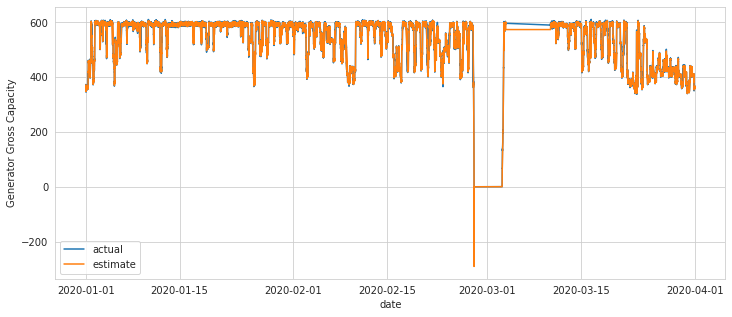

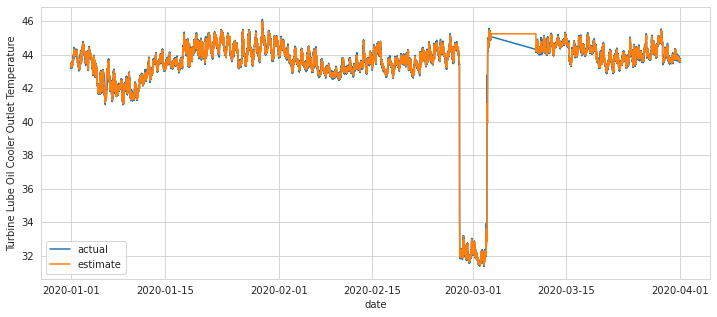

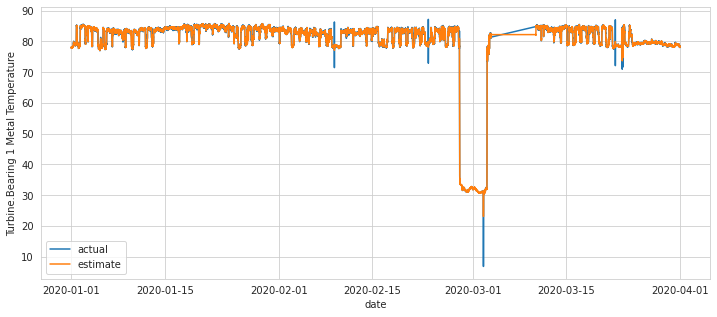

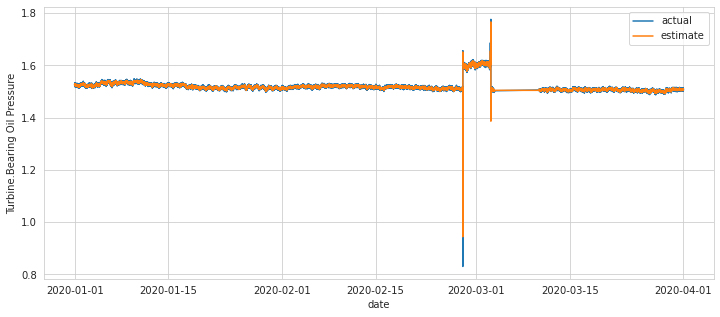

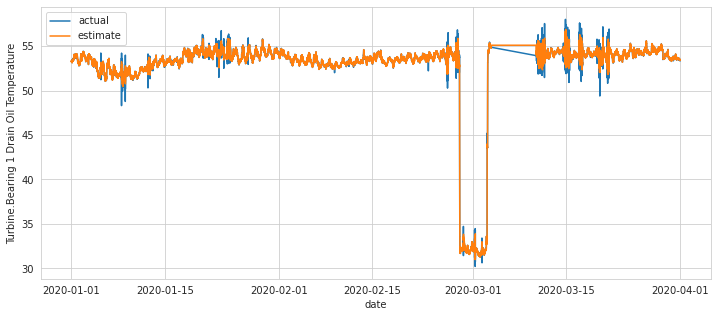

In [ ]:
# plot actual and estimate
for i,col in enumerate(cols):
    plt.figure(figsize=(12,5))
    sns.lineplot(data=df_actual, x="date", y=col)
    sns.lineplot(data=df_estimate, x="date", y=col)
    plt.legend(['actual','estimate'])
    plt.show();

In [ ]:
# plot residual and residual indication positive
# for i,col in enumerate(cols):
#     fig, ax1 = plt.subplots(figsize=(12,5))
#     ax2 = ax1.twinx()

#     ax1.plot(df_residual['date'], df_residual[col])
#     ax1.set_ylabel(col)
#     ax1.set_xlabel('date')

#     ax2.scatter(df_resid_ind_pos['date'], df_resid_ind_pos[col], color='green')
#     ax2.set_ylabel('Indication Positive', rotation=270, labelpad=20)
#     ax2.set_yticks(range(-1,2))

#     plt.show();

In [ ]:
# plot residual and residual indication negative
# for i,col in enumerate(cols):
#     fig, ax1 = plt.subplots(figsize=(12,5))
#     ax2 = ax1.twinx()

#     ax1.plot(df_residual['date'], df_residual[col])
#     ax1.set_ylabel(col)
#     ax1.set_xlabel('date')

#     ax2.scatter(df_resid_ind_neg['date'], df_resid_ind_neg[col], color='red')
#     ax2.set_ylabel('Indication Negative', rotation=270, labelpad=20)
#     ax2.set_yticks(range(-1,2))

#     plt.show();

### Data 2

In [ ]:
big_matrix = data2[cols].values.T
big_matrix.shape

(5, 175679)

In [ ]:
%%time
# Estimate t+1 sensor data
actuals = []
estimates = []
residuals = []
residual_ind_pos = []
residual_ind_neg = []
# state_matrix = state_matrix
state_matrix = np.load('data1_state_matrix.npy')

for i in range(big_matrix.shape[1]):
    current_actual = big_matrix[:, i]

    # calculate estimate value
    x_est, state_matrix = estimate_sensors(actual=current_actual,
                                           state_matrix=state_matrix,
                                           analytic_conf=analytic_configured)
    
    # calculate residual
    residual = calculate_residual(current_actual, x_est)

    # residual threshold
    model_conf = model_configured.values
    resid_ind_pos = []
    resid_ind_neg = []

    for j in range(N_TAG):
        residual_positive_th = model_conf[j][1]
        residual_negative_th = model_conf[j][0]

        resid_pos = residual_indication_positive_flag(residual[j], residual_positive_th)
        resid_neg = residual_indication_negative_flag(residual[j], residual_negative_th)
        
        resid_ind_pos.append(resid_pos)
        resid_ind_neg.append(resid_neg)
        
    # append to list
    actuals.append(current_actual)
    estimates.append(x_est)
    residuals.append(residual)
    residual_ind_pos.append(resid_ind_pos)
    residual_ind_neg.append(resid_ind_neg)
    
# convert to numpy array
actuals = np.array(actuals)
estimates = np.array(estimates)
residuals = np.array(residuals)
residual_ind_pos = np.array(residual_ind_pos)
residual_ind_neg = np.array(residual_ind_neg)

CPU times: user 45min 46s, sys: 3min 37s, total: 49min 24s
Wall time: 45min 2s


In [ ]:
# create data frame
df_actual = pd.DataFrame(actuals, columns=cols)
df_estimate = pd.DataFrame(estimates, columns=cols)
df_residual = pd.DataFrame(residuals, columns=cols)
df_resid_ind_pos = pd.DataFrame(residual_ind_pos, columns=cols)
df_resid_ind_neg = pd.DataFrame(residual_ind_neg, columns=cols)

# add date
df_actual['date'] = data2['date']
df_estimate['date'] = data2['date']
df_residual['date'] = data2['date']
df_resid_ind_pos['date'] = data2['date']
df_resid_ind_neg['date'] = data2['date']

In [ ]:
# export result
np.save('data2_state_matrix.npy', state_matrix)
df_actual.to_csv('data2_df_actual.csv', index=False)
df_estimate.to_csv('data2_df_estimate.csv', index=False)
df_residual.to_csv('data2_df_residual.csv', index=False)
df_resid_ind_pos.to_csv('data2_df_resid_ind_pos.csv', index=False)
df_resid_ind_neg.to_csv('data2_df_resid_ind_neg.csv', index=False)

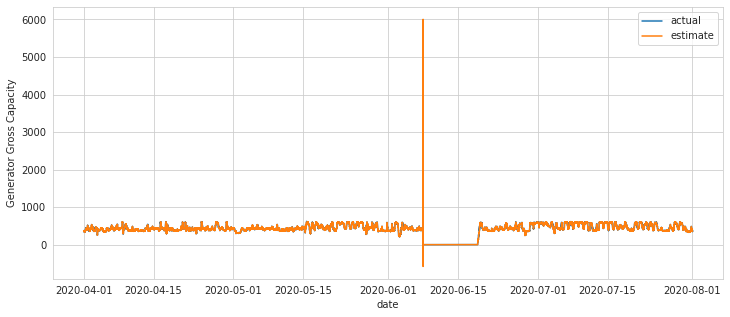

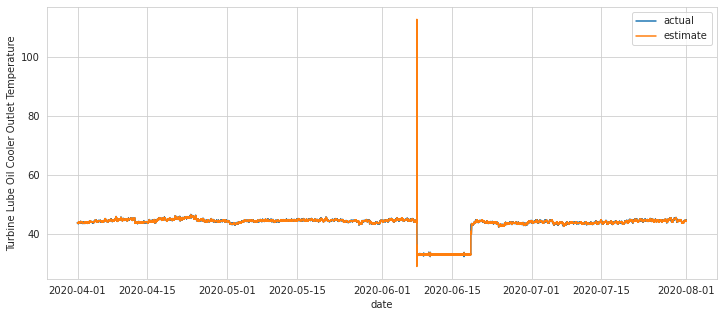

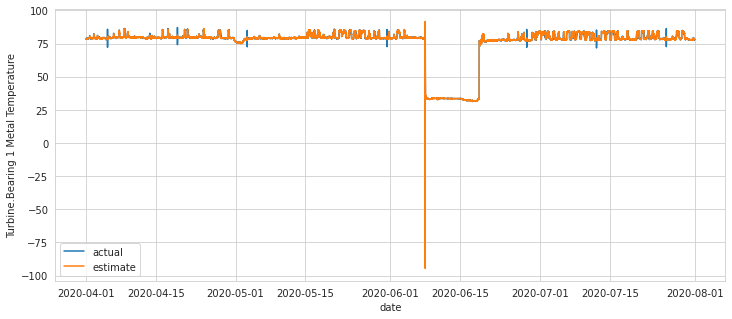

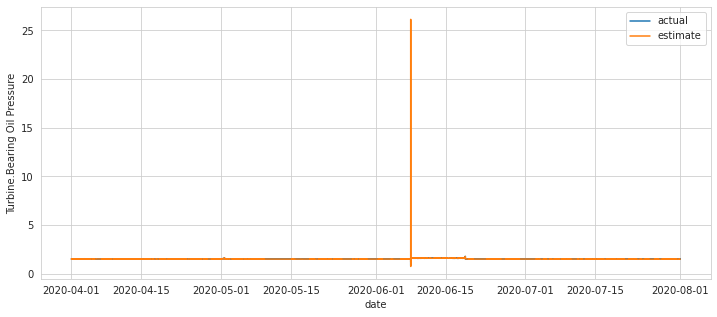

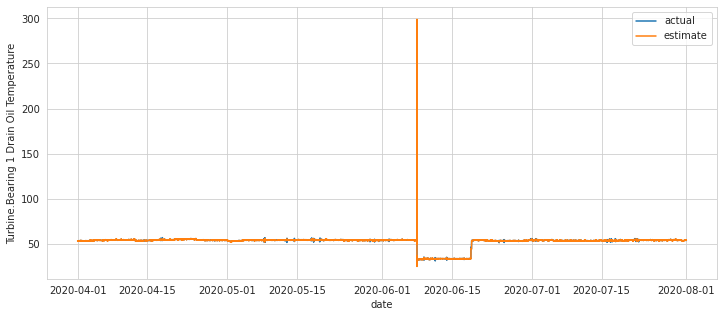

In [ ]:
# plot actual and estimate
for i,col in enumerate(cols):
    plt.figure(figsize=(12,5))
    sns.lineplot(data=df_actual, x="date", y=col)
    sns.lineplot(data=df_estimate, x="date", y=col)
    plt.legend(['actual','estimate'])
    plt.show();

### Data 3

In [ ]:
big_matrix = data3[cols].values.T
big_matrix.shape

(5, 220319)

In [ ]:
%%time
# Estimate t+1 sensor data
actuals = []
estimates = []
residuals = []
residual_ind_pos = []
residual_ind_neg = []
# state_matrix = state_matrix
state_matrix = np.load('data2_state_matrix.npy')

for i in range(big_matrix.shape[1]):
    current_actual = big_matrix[:, i]

    # calculate estimate value
    x_est, state_matrix = estimate_sensors(actual=current_actual,
                                           state_matrix=state_matrix,
                                           analytic_conf=analytic_configured)
    
    # calculate residual
    residual = calculate_residual(current_actual, x_est)

    # residual threshold
    model_conf = model_configured.values
    resid_ind_pos = []
    resid_ind_neg = []

    for j in range(N_TAG):
        residual_positive_th = model_conf[j][1]
        residual_negative_th = model_conf[j][0]

        resid_pos = residual_indication_positive_flag(residual[j], residual_positive_th)
        resid_neg = residual_indication_negative_flag(residual[j], residual_negative_th)
        
        resid_ind_pos.append(resid_pos)
        resid_ind_neg.append(resid_neg)
        
    # append to list
    actuals.append(current_actual)
    estimates.append(x_est)
    residuals.append(residual)
    residual_ind_pos.append(resid_ind_pos)
    residual_ind_neg.append(resid_ind_neg)
    
# convert to numpy array
actuals = np.array(actuals)
estimates = np.array(estimates)
residuals = np.array(residuals)
residual_ind_pos = np.array(residual_ind_pos)
residual_ind_neg = np.array(residual_ind_neg)

CPU times: user 57min 37s, sys: 4min 29s, total: 1h 2min 7s
Wall time: 56min 44s


In [ ]:
# create data frame
df_actual = pd.DataFrame(actuals, columns=cols)
df_estimate = pd.DataFrame(estimates, columns=cols)
df_residual = pd.DataFrame(residuals, columns=cols)
df_resid_ind_pos = pd.DataFrame(residual_ind_pos, columns=cols)
df_resid_ind_neg = pd.DataFrame(residual_ind_neg, columns=cols)

# add date
df_actual['date'] = data3['date']
df_estimate['date'] = data3['date']
df_residual['date'] = data3['date']
df_resid_ind_pos['date'] = data3['date']
df_resid_ind_neg['date'] = data3['date']

In [ ]:
# export result
np.save('data3_state_matrix.npy', state_matrix)
df_actual.to_csv('data3_df_actual.csv', index=False)
df_estimate.to_csv('data3_df_estimate.csv', index=False)
df_residual.to_csv('data3_df_residual.csv', index=False)
df_resid_ind_pos.to_csv('data3_df_resid_ind_pos.csv', index=False)
df_resid_ind_neg.to_csv('data3_df_resid_ind_neg.csv', index=False)

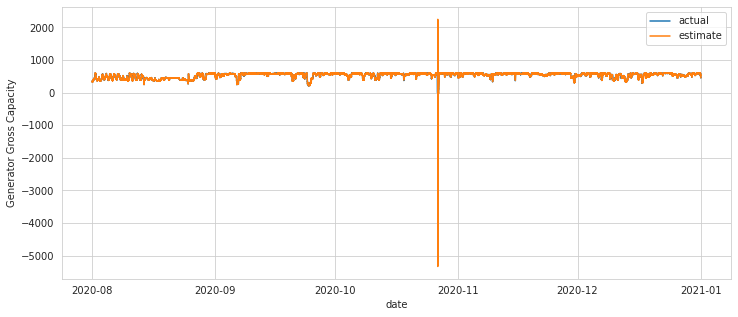

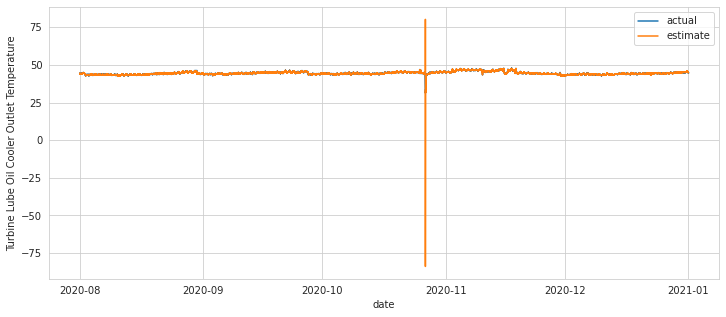

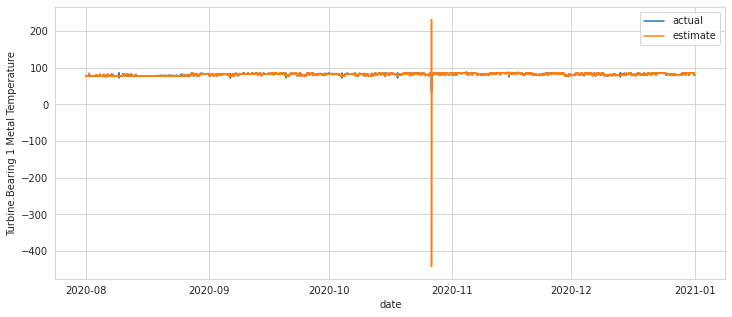

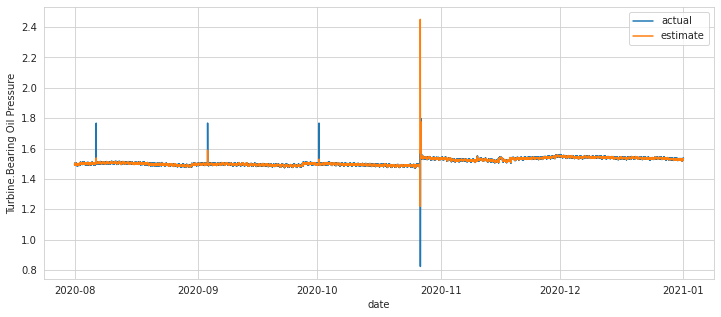

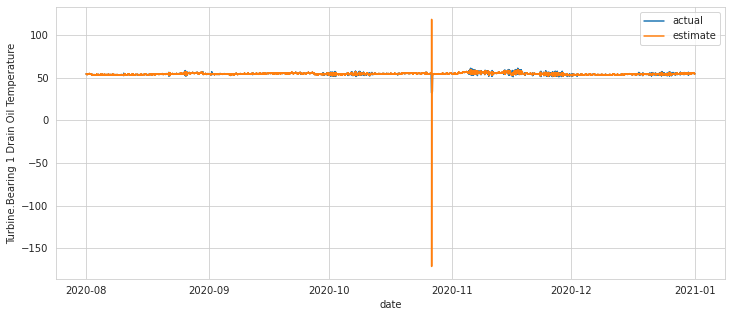

In [ ]:
# plot actual and estimate
for i,col in enumerate(cols):
    plt.figure(figsize=(12,5))
    sns.lineplot(data=df_actual, x="date", y=col)
    sns.lineplot(data=df_estimate, x="date", y=col)
    plt.legend(['actual','estimate'])
    plt.show();

### Data 4

In [ ]:
big_matrix = data4[cols].values.T
big_matrix.shape

(5, 129599)

In [ ]:
%%time
# Estimate t+1 sensor data
actuals = []
estimates = []
residuals = []
residual_ind_pos = []
residual_ind_neg = []
# state_matrix = state_matrix
state_matrix = np.load('data3_state_matrix.npy')

for i in range(big_matrix.shape[1]):
    current_actual = big_matrix[:, i]

    # calculate estimate value
    x_est, state_matrix = estimate_sensors(actual=current_actual,
                                           state_matrix=state_matrix,
                                           analytic_conf=analytic_configured)
    
    # calculate residual
    residual = calculate_residual(current_actual, x_est)

    # residual threshold
    model_conf = model_configured.values
    resid_ind_pos = []
    resid_ind_neg = []

    for j in range(N_TAG):
        residual_positive_th = model_conf[j][1]
        residual_negative_th = model_conf[j][0]

        resid_pos = residual_indication_positive_flag(residual[j], residual_positive_th)
        resid_neg = residual_indication_negative_flag(residual[j], residual_negative_th)
        
        resid_ind_pos.append(resid_pos)
        resid_ind_neg.append(resid_neg)
        
    # append to list
    actuals.append(current_actual)
    estimates.append(x_est)
    residuals.append(residual)
    residual_ind_pos.append(resid_ind_pos)
    residual_ind_neg.append(resid_ind_neg)
    
# convert to numpy array
actuals = np.array(actuals)
estimates = np.array(estimates)
residuals = np.array(residuals)
residual_ind_pos = np.array(residual_ind_pos)
residual_ind_neg = np.array(residual_ind_neg)

CPU times: user 33min 50s, sys: 2min 35s, total: 36min 26s
Wall time: 33min 17s


In [ ]:
# create data frame
df_actual = pd.DataFrame(actuals, columns=cols)
df_estimate = pd.DataFrame(estimates, columns=cols)
df_residual = pd.DataFrame(residuals, columns=cols)
df_resid_ind_pos = pd.DataFrame(residual_ind_pos, columns=cols)
df_resid_ind_neg = pd.DataFrame(residual_ind_neg, columns=cols)

# add date
df_actual['date'] = data4['date']
df_estimate['date'] = data4['date']
df_residual['date'] = data4['date']
df_resid_ind_pos['date'] = data4['date']
df_resid_ind_neg['date'] = data4['date']

In [ ]:
# export result
np.save('data4_state_matrix.npy', state_matrix)
df_actual.to_csv('data4_df_actual.csv', index=False)
df_estimate.to_csv('data4_df_estimate.csv', index=False)
df_residual.to_csv('data4_df_residual.csv', index=False)
df_resid_ind_pos.to_csv('data4_df_resid_ind_pos.csv', index=False)
df_resid_ind_neg.to_csv('data4_df_resid_ind_neg.csv', index=False)

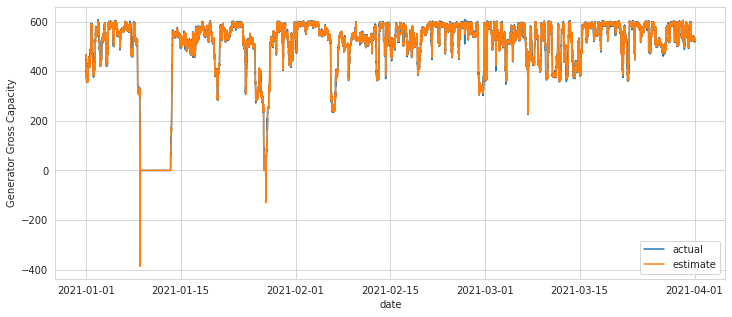

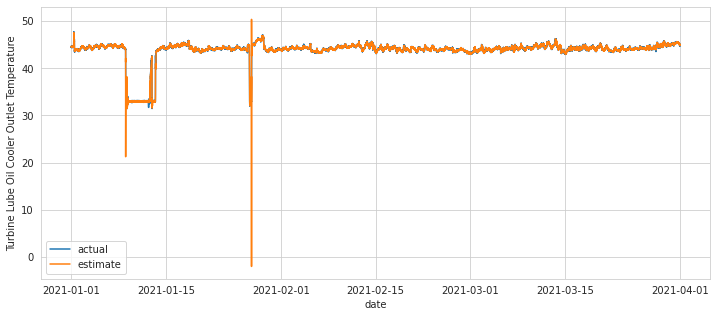

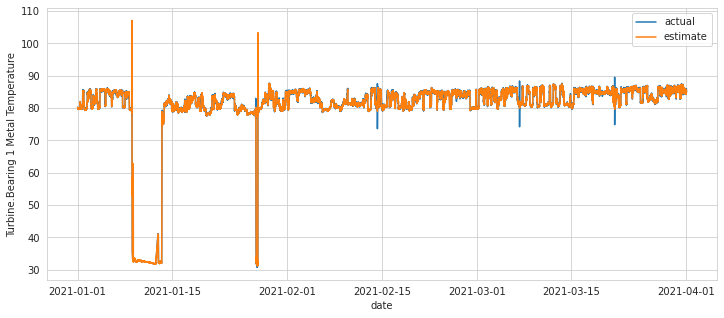

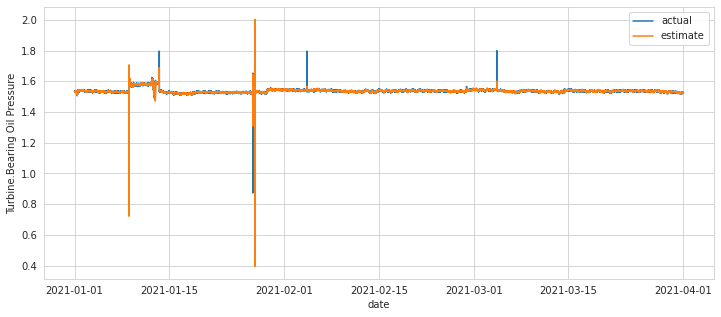

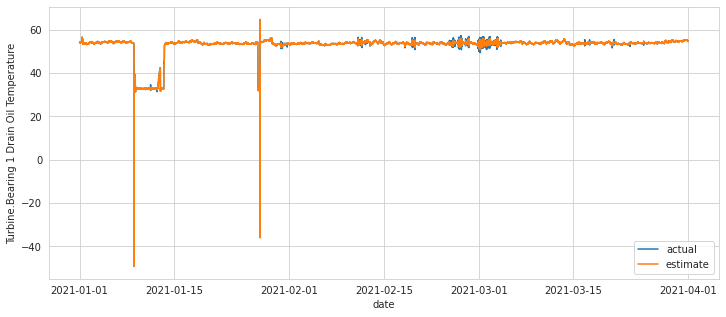

In [ ]:
# plot actual and estimate
for i,col in enumerate(cols):
    plt.figure(figsize=(12,5))
    sns.lineplot(data=df_actual, x="date", y=col)
    sns.lineplot(data=df_estimate, x="date", y=col)
    plt.legend(['actual','estimate'])
    plt.show();

### Data 5

In [ ]:
big_matrix = data5[cols].values.T
big_matrix.shape

(5, 175679)

In [ ]:
%%time
# Estimate t+1 sensor data
actuals = []
estimates = []
residuals = []
residual_ind_pos = []
residual_ind_neg = []
# state_matrix = state_matrix
state_matrix = np.load('data4_state_matrix.npy')

for i in range(big_matrix.shape[1]):
    current_actual = big_matrix[:, i]

    # calculate estimate value
    x_est, state_matrix = estimate_sensors(actual=current_actual,
                                           state_matrix=state_matrix,
                                           analytic_conf=analytic_configured)
    
    # calculate residual
    residual = calculate_residual(current_actual, x_est)

    # residual threshold
    model_conf = model_configured.values
    resid_ind_pos = []
    resid_ind_neg = []

    for j in range(N_TAG):
        residual_positive_th = model_conf[j][1]
        residual_negative_th = model_conf[j][0]

        resid_pos = residual_indication_positive_flag(residual[j], residual_positive_th)
        resid_neg = residual_indication_negative_flag(residual[j], residual_negative_th)
        
        resid_ind_pos.append(resid_pos)
        resid_ind_neg.append(resid_neg)
        
    # append to list
    actuals.append(current_actual)
    estimates.append(x_est)
    residuals.append(residual)
    residual_ind_pos.append(resid_ind_pos)
    residual_ind_neg.append(resid_ind_neg)
    
# convert to numpy array
actuals = np.array(actuals)
estimates = np.array(estimates)
residuals = np.array(residuals)
residual_ind_pos = np.array(residual_ind_pos)
residual_ind_neg = np.array(residual_ind_neg)

CPU times: user 47min 21s, sys: 4min 14s, total: 51min 35s
Wall time: 46min 29s


In [ ]:
# create data frame
df_actual = pd.DataFrame(actuals, columns=cols)
df_estimate = pd.DataFrame(estimates, columns=cols)
df_residual = pd.DataFrame(residuals, columns=cols)
df_resid_ind_pos = pd.DataFrame(residual_ind_pos, columns=cols)
df_resid_ind_neg = pd.DataFrame(residual_ind_neg, columns=cols)

# add date
df_actual['date'] = data5['date']
df_estimate['date'] = data5['date']
df_residual['date'] = data5['date']
df_resid_ind_pos['date'] = data5['date']
df_resid_ind_neg['date'] = data5['date']

In [ ]:
# export result
np.save('data5_state_matrix.npy', state_matrix)
df_actual.to_csv('data5_df_actual.csv', index=False)
df_estimate.to_csv('data5_df_estimate.csv', index=False)
df_residual.to_csv('data5_df_residual.csv', index=False)
df_resid_ind_pos.to_csv('data5_df_resid_ind_pos.csv', index=False)
df_resid_ind_neg.to_csv('data5_df_resid_ind_neg.csv', index=False)

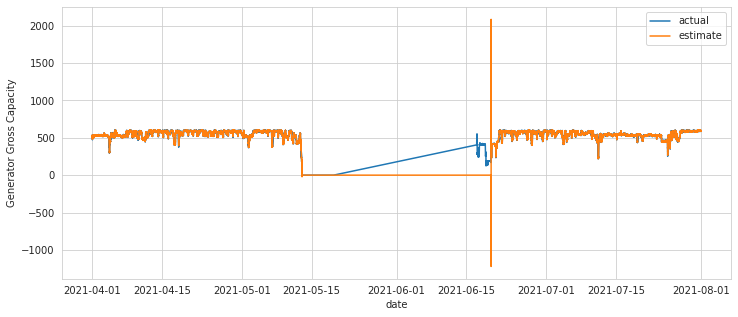

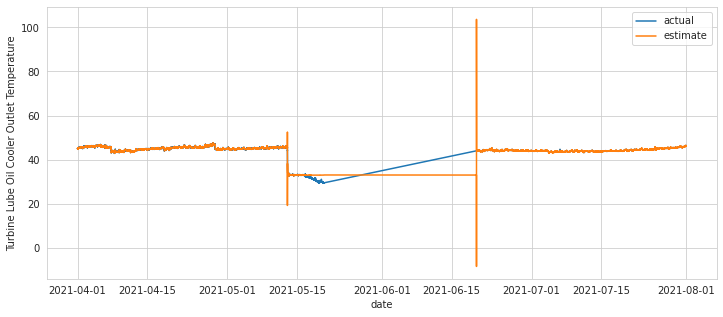

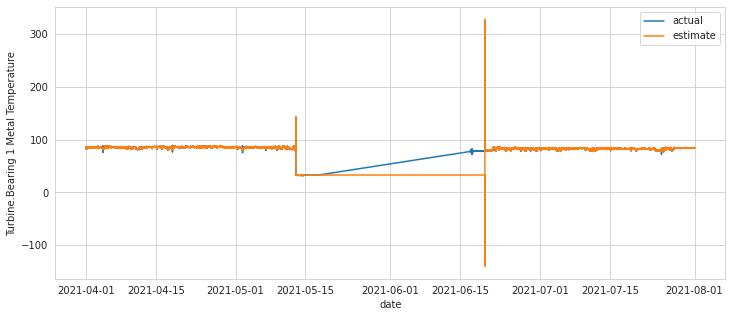

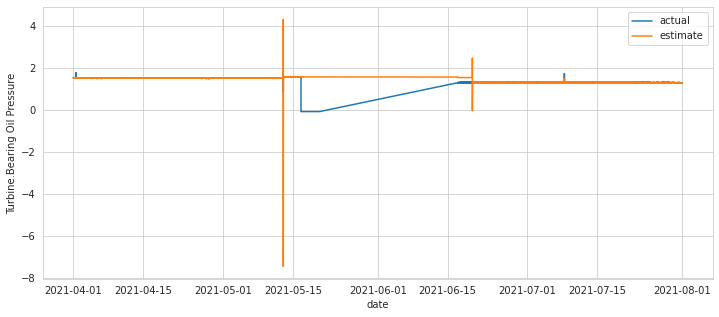

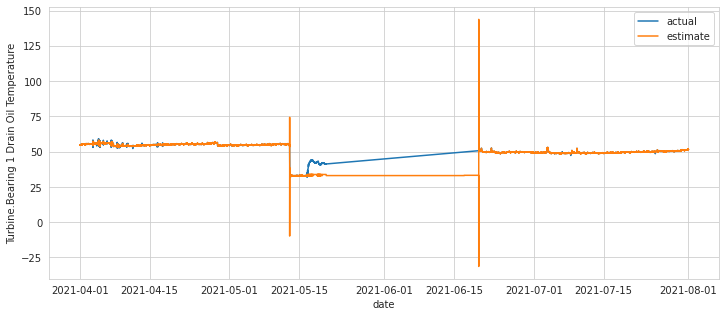

In [ ]:
# plot actual and estimate
for i,col in enumerate(cols):
    plt.figure(figsize=(12,5))
    sns.lineplot(data=df_actual, x="date", y=col)
    sns.lineplot(data=df_estimate, x="date", y=col)
    plt.legend(['actual','estimate'])
    plt.show();

### Data 6

In [ ]:
big_matrix = data6[cols].values.T
big_matrix.shape

(5, 132479)

In [ ]:
%%time
# Estimate t+1 sensor data
actuals = []
estimates = []
residuals = []
residual_ind_pos = []
residual_ind_neg = []
# state_matrix = state_matrix
state_matrix = np.load('data5_state_matrix.npy')

for i in range(big_matrix.shape[1]):
    current_actual = big_matrix[:, i]

    # calculate estimate value
    x_est, state_matrix = estimate_sensors(actual=current_actual,
                                           state_matrix=state_matrix,
                                           analytic_conf=analytic_configured)
    
    # calculate residual
    residual = calculate_residual(current_actual, x_est)

    # residual threshold
    model_conf = model_configured.values
    resid_ind_pos = []
    resid_ind_neg = []

    for j in range(N_TAG):
        residual_positive_th = model_conf[j][1]
        residual_negative_th = model_conf[j][0]

        resid_pos = residual_indication_positive_flag(residual[j], residual_positive_th)
        resid_neg = residual_indication_negative_flag(residual[j], residual_negative_th)
        
        resid_ind_pos.append(resid_pos)
        resid_ind_neg.append(resid_neg)
        
    # append to list
    actuals.append(current_actual)
    estimates.append(x_est)
    residuals.append(residual)
    residual_ind_pos.append(resid_ind_pos)
    residual_ind_neg.append(resid_ind_neg)
    
# convert to numpy array
actuals = np.array(actuals)
estimates = np.array(estimates)
residuals = np.array(residuals)
residual_ind_pos = np.array(residual_ind_pos)
residual_ind_neg = np.array(residual_ind_neg)

CPU times: user 35min 13s, sys: 2min 52s, total: 38min 6s
Wall time: 34min 38s


In [ ]:
# create data frame
df_actual = pd.DataFrame(actuals, columns=cols)
df_estimate = pd.DataFrame(estimates, columns=cols)
df_residual = pd.DataFrame(residuals, columns=cols)
df_resid_ind_pos = pd.DataFrame(residual_ind_pos, columns=cols)
df_resid_ind_neg = pd.DataFrame(residual_ind_neg, columns=cols)

# add date
df_actual['date'] = data6['date']
df_estimate['date'] = data6['date']
df_residual['date'] = data6['date']
df_resid_ind_pos['date'] = data6['date']
df_resid_ind_neg['date'] = data6['date']

In [ ]:
# export result
np.save('data6_state_matrix.npy', state_matrix)
df_actual.to_csv('data6_df_actual.csv', index=False)
df_estimate.to_csv('data6_df_estimate.csv', index=False)
df_residual.to_csv('data6_df_residual.csv', index=False)
df_resid_ind_pos.to_csv('data6_df_resid_ind_pos.csv', index=False)
df_resid_ind_neg.to_csv('data6_df_resid_ind_neg.csv', index=False)

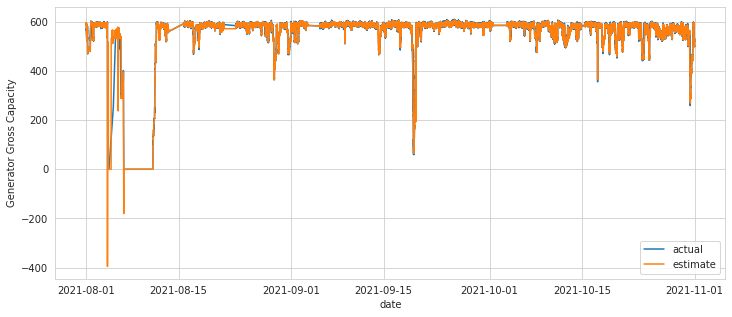

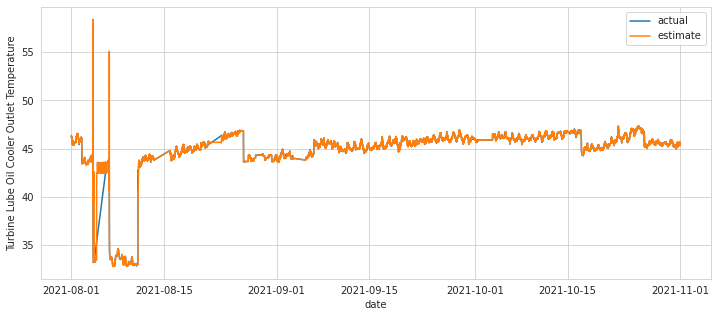

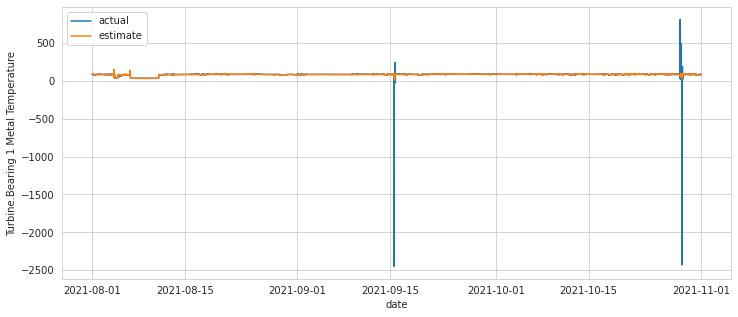

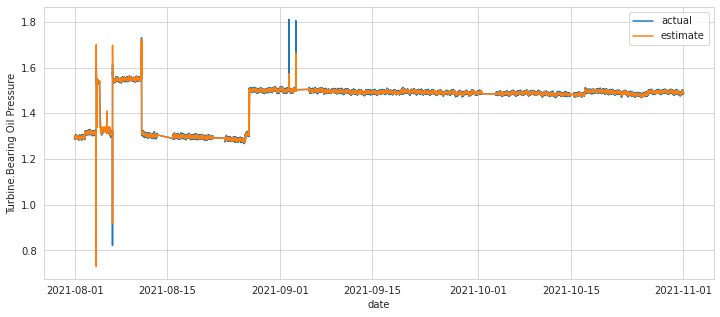

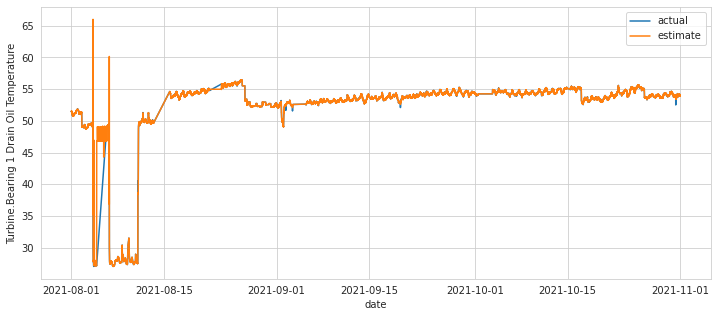

In [ ]:
# plot actual and estimate
for i,col in enumerate(cols):
    plt.figure(figsize=(12,5))
    sns.lineplot(data=df_actual, x="date", y=col)
    sns.lineplot(data=df_estimate, x="date", y=col)
    plt.legend(['actual','estimate'])
    plt.show();

## Rule Assignment

https://www.ge.com/digital/documentation/predix-apm/latest/r_apm_smartsignal_exp_syn_logical_functions.html

Function: `WindowRatio()`
- Description: This function looks at a window of data and compares it to a threshold. If the number of true comparisons is greater than or equal to the `trueSize` than `windowRatio` will return `true` otherwise it will return `false`.
    - Integer `trueSize`, The trueSize specifies the number of true comparison must be found in the window (specified in values) for windowRatio to return `True`. When a `NaN` present in values the `TrueSize` is divided by the window to create a ratio (or percentage) for which 
    - List values, A list of tag values to be compared to the threshold. The window size is specified by the size of the list. E.g. `Tag.Actual(20)` is a window of 20 
    - String comparisonOperator,  Specifies how to compare the values to the threshold. Valid options are: `=`, `>`, `<`, `>=`, `<=`, `!=`. The operator must be in quotes, `“=”`
    - Float threshold, A threshold that the values will be compared to
    - Integer requiredGoodSize, The required number of numeric values. If the number of numeric (non `NaN`s) in values is less than this value `windowRatio` will return `false`. Typically `requiredGoodSize` is about `one half the window size.`
- Example: `WindowRatio(17, Tag.ResidualIndicationPositive(18), ”=”, 1, 9)`

---

Function: `isStep()`
- Description: This function returns true if there is a step change in values provided.

    `Olympic smoothing` will be performed on the values provided (excluding the most recent observation) to obtain the `averageValue` previous to the most recent observation. The two most recent observations will be compared to the `averageValue` evaluating the difference. A step change is determined if for both comparisons:

    ```value – averageValue > |stepUpThreshold| or value – averageValue < -|stepDownThreshold|```

    - `values`: A set of tag history containing at least 4 observations E.g. `Tag.Actual(7)`
    - `stepUpThreshold`: Required magnitude of the step change in the positive direction. Step up can be ignored by specifying a stepUpThreshold of NaN()
    - `stepDownThreshold`: Required magnitude of the step change in the negative direction. Step down can be ignored by specifying a stepUpThreshold of NaN()
- Example: `isStep(Tag.Actual(7), Tag.StepHigh, Tag.StepLow)`

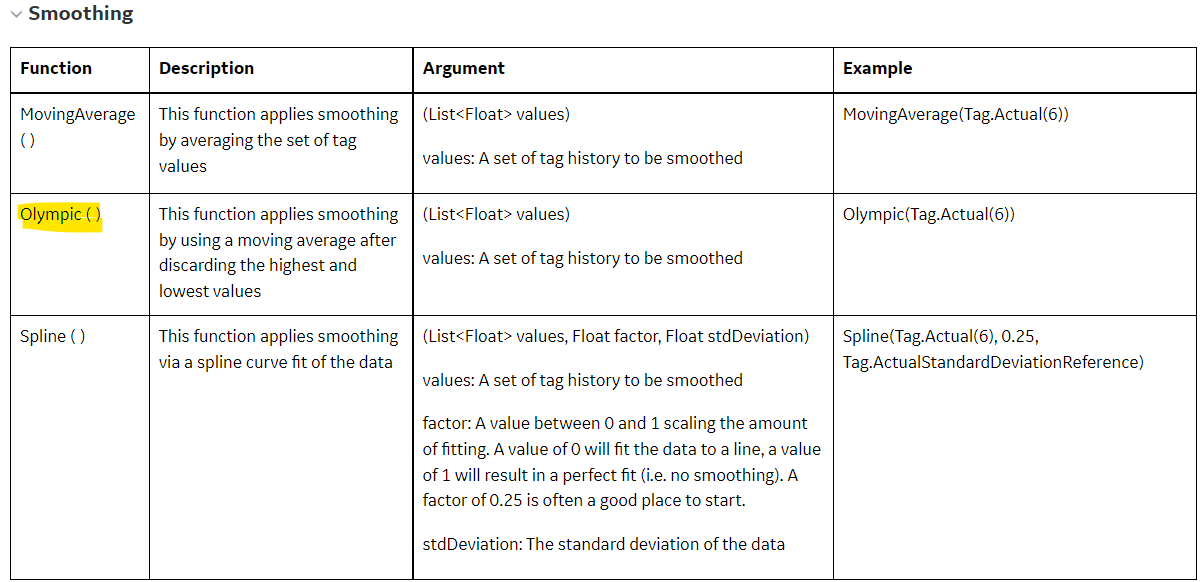

In [21]:
# actual_df = df_actual.copy().set_index('date')
# estimate_df = df_estimate.copy().set_index('date')
# residual_df = df_residual.copy().set_index('date')
# resid_indpos_df = df_resid_ind_pos.copy().set_index('date')
# resid_indneg_df = df_resid_ind_neg.copy().set_index('date')

In [22]:
# load data
data1_actual = pd.read_csv('data1_df_actual.csv')
data1_estimate = pd.read_csv('data1_df_estimate.csv')
data1_residual = pd.read_csv('data1_df_residual.csv')
data1_resid_ind_neg = pd.read_csv('data1_df_resid_ind_neg.csv')
data1_resid_ind_pos = pd.read_csv('data1_df_resid_ind_pos.csv')

data2_actual = pd.read_csv('data2_df_actual.csv')
data2_estimate = pd.read_csv('data2_df_estimate.csv')
data2_residual = pd.read_csv('data2_df_residual.csv')
data2_resid_ind_neg = pd.read_csv('data2_df_resid_ind_neg.csv')
data2_resid_ind_pos = pd.read_csv('data2_df_resid_ind_pos.csv')

data3_actual = pd.read_csv('data3_df_actual.csv')
data3_estimate = pd.read_csv('data3_df_estimate.csv')
data3_residual = pd.read_csv('data3_df_residual.csv')
data3_resid_ind_neg = pd.read_csv('data3_df_resid_ind_neg.csv')
data3_resid_ind_pos = pd.read_csv('data3_df_resid_ind_pos.csv')

data4_actual = pd.read_csv('data4_df_actual.csv')
data4_estimate = pd.read_csv('data4_df_estimate.csv')
data4_residual = pd.read_csv('data4_df_residual.csv')
data4_resid_ind_neg = pd.read_csv('data4_df_resid_ind_neg.csv')
data4_resid_ind_pos = pd.read_csv('data4_df_resid_ind_pos.csv')

data5_actual = pd.read_csv('data5_df_actual.csv')
data5_estimate = pd.read_csv('data5_df_estimate.csv')
data5_residual = pd.read_csv('data5_df_residual.csv')
data5_resid_ind_neg = pd.read_csv('data5_df_resid_ind_neg.csv')
data5_resid_ind_pos = pd.read_csv('data5_df_resid_ind_pos.csv')

data6_actual = pd.read_csv('data6_df_actual.csv')
data6_estimate = pd.read_csv('data6_df_estimate.csv')
data6_residual = pd.read_csv('data6_df_residual.csv')
data6_resid_ind_neg = pd.read_csv('data6_df_resid_ind_neg.csv')
data6_resid_ind_pos = pd.read_csv('data6_df_resid_ind_pos.csv')

In [23]:
# convert date to datetime
data1_actual['date'] = pd.to_datetime(data1_actual['date'])
data1_estimate['date'] = pd.to_datetime(data1_estimate['date'])
data1_residual['date'] = pd.to_datetime(data1_residual['date'])
data1_resid_ind_neg['date'] = pd.to_datetime(data1_resid_ind_neg['date'])
data1_resid_ind_pos['date'] = pd.to_datetime(data1_resid_ind_pos['date'])

data2_actual['date'] = pd.to_datetime(data2_actual['date'])
data2_estimate['date'] = pd.to_datetime(data2_estimate['date'])
data2_residual['date'] = pd.to_datetime(data2_residual['date'])
data2_resid_ind_neg['date'] = pd.to_datetime(data2_resid_ind_neg['date'])
data2_resid_ind_pos['date'] = pd.to_datetime(data2_resid_ind_pos['date'])

data3_actual['date'] = pd.to_datetime(data3_actual['date'])
data3_estimate['date'] = pd.to_datetime(data3_estimate['date'])
data3_residual['date'] = pd.to_datetime(data3_residual['date'])
data3_resid_ind_neg['date'] = pd.to_datetime(data3_resid_ind_neg['date'])
data3_resid_ind_pos['date'] = pd.to_datetime(data3_resid_ind_pos['date'])

data4_actual['date'] = pd.to_datetime(data4_actual['date'])
data4_estimate['date'] = pd.to_datetime(data4_estimate['date'])
data4_residual['date'] = pd.to_datetime(data4_residual['date'])
data4_resid_ind_neg['date'] = pd.to_datetime(data4_resid_ind_neg['date'])
data4_resid_ind_pos['date'] = pd.to_datetime(data4_resid_ind_pos['date'])

data5_actual['date'] = pd.to_datetime(data5_actual['date'])
data5_estimate['date'] = pd.to_datetime(data5_estimate['date'])
data5_residual['date'] = pd.to_datetime(data5_residual['date'])
data5_resid_ind_neg['date'] = pd.to_datetime(data5_resid_ind_neg['date'])
data5_resid_ind_pos['date'] = pd.to_datetime(data5_resid_ind_pos['date'])

data6_actual['date'] = pd.to_datetime(data6_actual['date'])
data6_estimate['date'] = pd.to_datetime(data6_estimate['date'])
data6_residual['date'] = pd.to_datetime(data6_residual['date'])
data6_resid_ind_neg['date'] = pd.to_datetime(data6_resid_ind_neg['date'])
data6_resid_ind_pos['date'] = pd.to_datetime(data6_resid_ind_pos['date'])

In [24]:
data1 = {'df_actual': data1_actual.copy().set_index('date'),
         'df_estimate': data1_estimate.copy().set_index('date'),
         'df_residual': data1_residual.copy().set_index('date'),
         'df_resid_ind_pos': data1_resid_ind_pos.copy().set_index('date'),
         'df_resid_ind_neg': data1_resid_ind_neg.copy().set_index('date')}

data2 = {'df_actual': data2_actual.copy().set_index('date'),
         'df_estimate': data2_estimate.copy().set_index('date'),
         'df_residual': data2_residual.copy().set_index('date'),
         'df_resid_ind_pos': data2_resid_ind_pos.copy().set_index('date'),
         'df_resid_ind_neg': data2_resid_ind_neg.copy().set_index('date')}

data3 = {'df_actual': data3_actual.copy().set_index('date'),
         'df_estimate': data3_estimate.copy().set_index('date'),
         'df_residual': data3_residual.copy().set_index('date'),
         'df_resid_ind_pos': data3_resid_ind_pos.copy().set_index('date'),
         'df_resid_ind_neg': data3_resid_ind_neg.copy().set_index('date')}

data4 = {'df_actual': data4_actual.copy().set_index('date'),
         'df_estimate': data4_estimate.copy().set_index('date'),
         'df_residual': data4_residual.copy().set_index('date'),
         'df_resid_ind_pos': data4_resid_ind_pos.copy().set_index('date'),
         'df_resid_ind_neg': data4_resid_ind_neg.copy().set_index('date')}

data5 = {'df_actual': data5_actual.copy().set_index('date'),
         'df_estimate': data5_estimate.copy().set_index('date'),
         'df_residual': data5_residual.copy().set_index('date'),
         'df_resid_ind_pos': data5_resid_ind_pos.copy().set_index('date'),
         'df_resid_ind_neg': data5_resid_ind_neg.copy().set_index('date')}

data6 = {'df_actual': data6_actual.copy().set_index('date'),
         'df_estimate': data6_estimate.copy().set_index('date'),
         'df_residual': data6_residual.copy().set_index('date'),
         'df_resid_ind_pos': data6_resid_ind_pos.copy().set_index('date'),
         'df_resid_ind_neg': data6_resid_ind_neg.copy().set_index('date')}

In [25]:
from datetime import timedelta

class Tag(object):

    def __init__(self, name, date, data):
        self.name = name
        self.date = date
        self.actual = []
        self.residual = []
        self.residual_indication_positive = []
        self.residual_indication_negative = []
        self.residual_positive_threshold = self.get_residual_positive_threshold()
        self.residual_negative_threshold = self.get_residual_negative_threshold()
        # additional params
        self.actual_df = data['df_actual']
        self.estimate_df = data['df_estimate']
        self.residual_df = data['df_residual']
        self.resid_indpos_df = data['df_resid_ind_pos']
        self.resid_indneg_df = data['df_resid_ind_neg']
        

    def Actual(self, n=1):
        start_date = self.get_start_date(self.date, n)
        self.actual = self.actual_df.loc[start_date:self.date][self.name]
        return self.actual.values
    
    def Residual(self, n=1):
        start_date = self.get_start_date(self.date, n)
        self.residual = self.residual_df.loc[start_date:self.date][self.name]
        return self.residual.values
    
    def ResidualIndicationPositive(self, n=1):
        start_date = self.get_start_date(self.date, n)
        self.residual_indication_positive = self.resid_indpos_df.loc[start_date:self.date][self.name]
        return self.residual_indication_positive.values

    def ResidualIndicationNegative(self, n=1):
        start_date = self.get_start_date(self.date, n)
        self.residual_indication_negative = self.resid_indneg_df.loc[start_date:self.date][self.name]
        return self.residual_indication_negative.values
    
    def ResidualPositiveThreshold(self):
        return self.residual_positive_threshold

    def ResidualNegativeThreshold(self):
        return self.residual_negative_threshold

    def get_start_date(self, date, n):
        return  pd.to_datetime(date) - timedelta(minutes=n-1)

    def get_residual_positive_threshold(self):
        return model_configured.loc[self.name]['ResidualPositiveThreshold']

    def get_residual_negative_threshold(self):
        return model_configured.loc[self.name]['ResidualNegativeThreshold']

In [26]:
# df_actual[df_actual['Generator Gross Capacity'].isnull()].head()

In [27]:
# example
tag = Tag(name="Generator Gross Capacity",
          date='2020-01-01 09:10:00',
          data=data1)
tag.Actual(18)

array([458.1123  , 458.579559, 458.088318, 456.565369, 460.143921,
       457.721252, 457.914948, 458.192322, 458.687622, 461.552979,
       458.3939  , 459.102844, 458.716675, 458.199768, 459.4014  ,
       458.8157  , 459.705658, 457.794861])

In [28]:
# np.isnan(tag.Actual(18)).any()
not_nan = [val for val in tag.Actual(18) if ~np.isnan(val)]
not_nan

[458.1123,
 458.579559,
 458.088318,
 456.565369,
 460.143921,
 457.721252,
 457.914948,
 458.192322,
 458.687622,
 461.552979,
 458.3939,
 459.10284400000006,
 458.716675,
 458.199768,
 459.4014,
 458.8157,
 459.705658,
 457.794861]

In [29]:
import operator

comp_operator = {
    '=': operator.eq,
    '>': operator.gt,
    '<': operator.lt,
    '>=': operator.ge,
    '<=': operator.le,
    '!=': operator.ne
}

def window_ratio(true_size, values, comparison, threshold, required_size):
    # check required good size
    if np.count_nonzero(~np.isnan(values)) < required_size: return False

    # check if nan available in data
    if np.isnan(values).any():  # there is/are nan/s
        # calculate ratio true size
        ratio_true_size = true_size / len(values)
        
        # filter non nan
        non_nan = [val for val in values if ~np.isnan(val)]

        # compare values with threshold
        comp = [True if comp_operator.get(comparison)(v,threshold) else False for v in non_nan]
        ratio_non_nan = np.sum(comp) / len(comp)

        return True if ratio_non_nan >= ratio_true_size else False
    else: # there is not nan
        # compare values with threshold
        comp = [True if comp_operator.get(comparison)(v,threshold) else False for v in values]
        # check the number of true comparisons and compare them with true_size
        return True if np.sum(comp) >= true_size else False

def moving_average(a, n=2) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def smoothing(values, fn="olympic"):
    if fn == "olympic":
        # delete min and max value
        values = np.delete(values, values.argmin())
        values = np.delete(values, values.argmax())
        # moving average with window = 2 
        values = moving_average(values, n=2)
        return values

def is_step(values, step_up_threshold, step_down_threshold):
    # check values
    if len(values) < 4: return False
    
    # exclude the most recent values
    history = values[:-1]
    history = smoothing(history)
    avg_value = np.mean(history)

    # get the two most recent observation
    obs = values[-2:]

    # check NaN
    if step_up_threshold == "NaN":
        rule_val1 = obs[0] - avg_value < -abs(step_down_threshold)
        rule_val2 = obs[1] - avg_value < -abs(step_down_threshold)
    elif step_down_threshold == "NaN":
        rule_val1 = obs[0] - avg_value > abs(step_up_threshold)
        rule_val2 = obs[1] - avg_value > abs(step_up_threshold)
    else:
        rule_val1 = (obs[0] - avg_value > abs(step_up_threshold)) or (obs[0] - avg_value < -abs(step_down_threshold))
        rule_val2 = (obs[1] - avg_value > abs(step_up_threshold)) or (obs[1] - avg_value < -abs(step_down_threshold))

    return rule_val1 and rule_val2

### High (H)

**Expressions:**

```
(WindowRatio(16, Tag.ResidualIndicationPositive(18), "=", 1, 9)) And 
(Tag.Residual >= Tag.ResidualPositiveThreshold)
```

In [30]:
def high(tag) -> bool:
    rule1 = window_ratio(16, tag.ResidualIndicationPositive(18), "=", 1, 9)
    rule2 = tag.Residual(1) >= tag.ResidualPositiveThreshold()
    return rule1 and rule2

In [31]:
tag = Tag(name="Generator Gross Capacity", 
          date="2021-08-01 00:07:00",
          data=data6)

high(tag)

False

### Very High (VH)

Expressions:
```
(WindowRatio(8, Tag.ResidualIndicationPositive(9), "=", 1, 6)) And 
(WindowRatio(6, Tag.Residual(9), ">=", (2.0* TagResidualPositiveThreshold), 6)) and
(Tag.Residual>=(2.0* Tag.ResidualPositiveThreshold))
```

In [32]:
def very_high(tag) -> bool:
    rule1 = window_ratio(8, tag.ResidualIndicationPositive(9), "=", 1, 6)
    rule2 = window_ratio(6, tag.Residual(9), ">=", (2.*tag.ResidualPositiveThreshold()),6)
    rule3 = tag.Residual(1) >= (2.*tag.ResidualPositiveThreshold())
    return rule1 and rule2 and rule3

In [33]:
tag = Tag(name="Generator Gross Capacity", 
          date="2021-08-01 00:07:00",
          data=data6)

very_high(tag)

False

### Step High (SH)

**Expressions:**
```
IsStep(Tag.Actual(7), 2.5* Tag.ResidualPositiveThreshold, NaN()) And
(Tag.Residual>(1.5* Tag.ResidualPositiveThreshold))
```

In [34]:
def step_high(tag) -> bool:
    rule1 = is_step(values=tag.Actual(7), 
                    step_up_threshold=2.5*tag.ResidualPositiveThreshold(),
                    step_down_threshold="NaN")
    rule2 = tag.Residual(1) > 1.5*tag.ResidualPositiveThreshold()
    return rule1 and rule2

In [35]:
tag = Tag(name="Generator Gross Capacity", 
          date="2021-08-01 00:07:00",
          data=data6)

step_high(tag)

False

### Step Very High (SVH)

**Expressions:**
```
IsStep(Tag.Actual(7), 3.0*Tag.ResidualPositiveThreshold, NaN()) and 
(Tag.Residual > (2.0*Tag.ResidualPositiveThreshold)) and 
Tag.ResidualIndicationPositive=1
```

In [36]:
def step_very_high(tag) -> bool:
    rule1 = is_step(values=tag.Actual(7), 
                    step_up_threshold=3.*tag.ResidualPositiveThreshold(),
                    step_down_threshold="NaN")
    rule2 = tag.Residual(1) > 2.*tag.ResidualPositiveThreshold()
    rule3 = tag.ResidualIndicationPositive(1) == 1
    return rule1 and rule2 and rule3

In [37]:
tag = Tag(name="Generator Gross Capacity", 
          date="2021-08-01 00:07:00",
          data=data6)

step_very_high(tag)

False

### Variance (VAR)

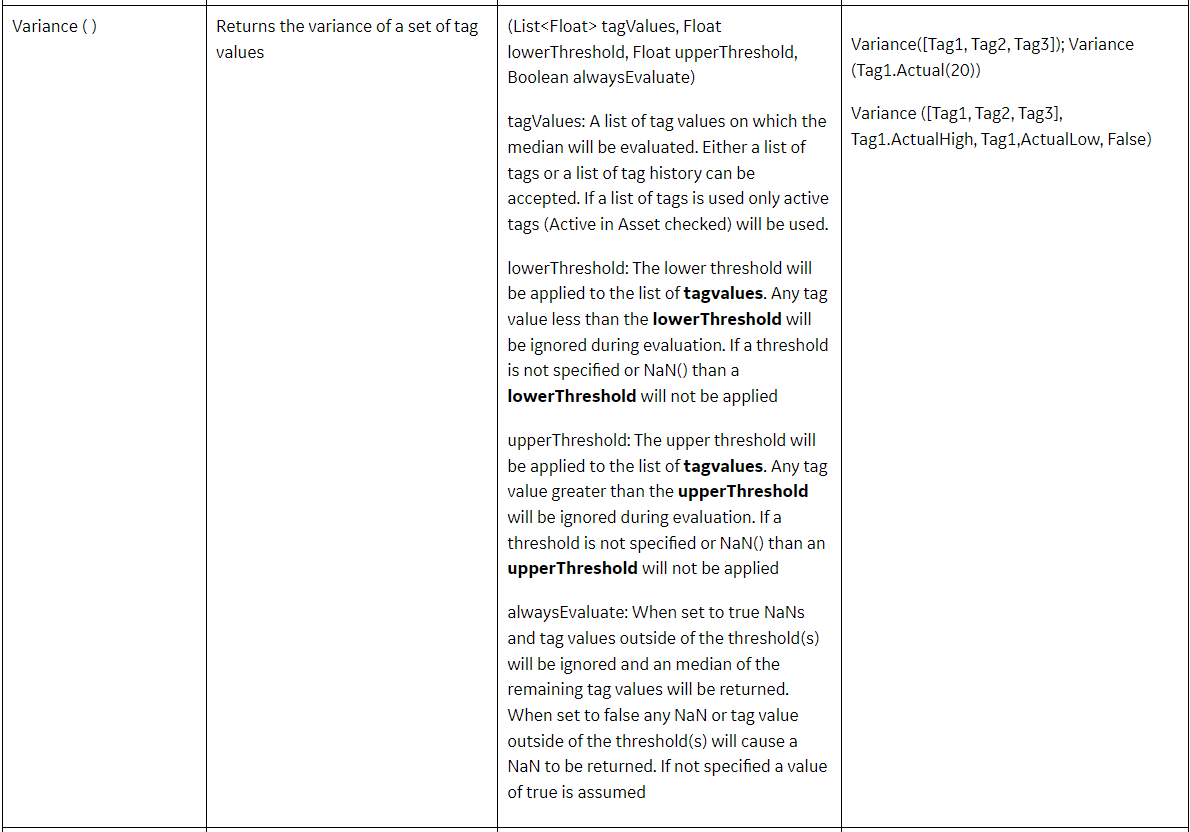

Expressions:
```
(Variance(Tag.Residual(18)) > (4*Minimum([abs(Tag.ResidualPositiveThreshold), abs(Tag.ResidualNegativeThreshold)])^2))
And 
WindowRatio(2, Tag.Residual(6),"">="",Minimum([abs(Tag.ResidualPositiveThreshold), abs(Tag.ResidualNegativeThreshold)]),4)
And 
WindowRatio(2,Tag.Residual(6),""<="",(-1)*Minimum([abs(Tag.ResidualPositiveThreshold), abs(Tag.ResidualNegativeThreshold)]),4)
```

In [38]:
def math_variance(values, lower_threshold="NaN", upper_threshold="NaN"):
    # variance with threshold not implemented yet
    return np.var(values)

def math_minimum(values, lower_threshold="NaN", upper_threshold="NaN"):
    # minimum with threshold not implemented yet
    return np.min(values)

def variance(tag) -> bool:
    rule1 = math_variance(tag.Residual(18)) > (4*math_minimum([abs(tag.ResidualPositiveThreshold()), abs(tag.ResidualPositiveThreshold())])**2)
    rule2 = window_ratio(true_size=2, 
                         values=tag.Residual(6), 
                         comparison=">=", 
                         threshold=math_minimum([abs(tag.ResidualPositiveThreshold()), abs(tag.ResidualPositiveThreshold())]),
                         required_size=4)
    rule3 = window_ratio(true_size=2, 
                         values=tag.Residual(6), 
                         comparison="<=", 
                         threshold=-1*math_minimum([abs(tag.ResidualPositiveThreshold()), abs(tag.ResidualPositiveThreshold())]),
                         required_size=4)
    return rule1 and rule2 and rule3

In [39]:
tag = Tag(name="Generator Gross Capacity", 
          date="2021-08-01 00:07:00",
          data=data6)

variance(tag)

False

## Model Diagnostic

**Modified Expressions:**

```
if
    (ModelIndications(MECHANICAL,[SVH,SH,VH],[Turbine.Bearing 1 Drain Oil Temperature])>=1.0
    and
    ModelIndications(MECHANICAL,[SVH,SH,VH],[Turbine.Bearing 1 Metal Temperature])>=1.0)
then 
    Priority(2)
else if
    (ModelIndications(MECHANICAL,[SVH,SH,VH],[Turbine.Bearing 1 Drain Oil Temperature])>=1.0
    or 
        (ModelIndications(MECHANICAL,[VAR,H],[Turbine.Bearing 1 Drain Oil Temperature])>=1.0
        and
        ModelIndications(MECHANICAL,[VAR,H],[Turbine.Bearing 1 Metal Temperature])>=1.0))
then 
    Priority(3)
else if
    (ModelIndications(MECHANICAL,[VAR,H],[Turbine.Bearing 1 Drain Oil Temperature])>=1.0)
then 
    Priority(4)
else
    IsAssociated(MECHANICAL,[GROSS_LOAD,AMBIENT_TEMP,LUBE_OIL_COOLER_OIL_OUTLET_TEMP, LUBE_OIL_COOLER_OIL_OUTLET_PRESS])
```

Function: `ModelIndications()`
- Description: Returns a count of the number of model tag advisory indications on a set of model tags.

    An advisory indication exists when the conditional logic of the rule evaluates to true for the model tag. Using the ModelIndications() function will assign each of the model rules to each of the model tags. When the conditional logic is met the advisory indication chart marker will be displayed in Sentinel.
    - `model`: A name of a model in the asset blueprint. Only one model may be specified. All modelTagRules will counted from this model only

    - `modelTagRules`: A list of model blueprint tag rules (mnemonics). Model blueprint tag rules are specified on the Rules tab of Blueprint Center (in green)

    - `assetTags`: A list of asset blueprint tags aliases. Asset blueprint tags are specified on the Tags sub tab of the Asset Blueprints tab. If the asset blueprint tag alias is not assigned to the model then model tag advisory indications cannot be created
- Example: `If (ModelIndications(Mechanical,[H],[Tag1, Tag2]) >=2 ) then …`

In [40]:
# tag rules dictionary
rules = {
    'H': high,
    'VH': very_high,
    'SH': step_high,
    'SVH': step_very_high,
    'VAR': variance,
}

def pair_rule_and_asset(tag_rules, asset_tags):
    result = []
    for rule in tag_rules:
        for asset in asset_tags:
            result.append((rule, asset))
    return result

def model_indications(model, tag_rules, asset_tags, date, data):
    indication = []

    for rule, asset in pair_rule_and_asset(tag_rules, asset_tags):
        # initialize tag
        tag = Tag(name=asset, date=date, data=data)
        # assign rule
        ind = rules.get(rule)(tag)
        indication.append(ind)

    return np.sum(indication)

In [41]:
# example
tag_rules = ['SVH', 'SH', 'VH']
asset_tags = ['Turbine.Bearing 1 Drain Oil Temperature']

model_indications('Mechanical', tag_rules, asset_tags, "2021-08-01 00:07:00", data6)

0

Function: `IsAssociated ( )`
- Description: Used to complete diagnostic logic as well as associated model tags with diagnostic logic

    Associated tags will be displayed in the diagnostic advisory folder in Sentinel’s asset explorer. Any model tag used in Modelindications() is automatically associated with the diagnostic
    - `model`: A name of a model in the asset blueprint. Only one model may be specified
    - `assetTags`: A list of asset tags to associated with the diagnostic. If the asset blueprint tag alias is not assigned to model no association will be created
- Example: `If (ModelIndications(Mechanical,[H],[Tag1, Tag2]) >=2 ) then Priority(5) else IsAssociated(Mechanical,[Tag3])`

In [42]:
# ???
def is_associated(model, asset_tags):
    return 0

**Modified Expressions:**

```
if
    (ModelIndications(MECHANICAL,[SVH,SH,VH],[Turbine.Bearing 1 Drain Oil Temperature])>=1.0
    and
    ModelIndications(MECHANICAL,[SVH,SH,VH],[Turbine Bearing #01 Metal Temperature, Turbine.Bearing 1 Metal Temperature])>=1.0)
then 
    Priority(2)
else if
    (ModelIndications(MECHANICAL,[SVH,SH,VH],[Turbine.Bearing 1 Drain Oil Temperature])>=1.0
    or 
        (ModelIndications(MECHANICAL,[VAR,H],[Turbine.Bearing 1 Drain Oil Temperature])>=1.0
        and
        ModelIndications(MECHANICAL,[VAR,H],[Turbine Bearing #01 Metal Temperature, Turbine.Bearing 1 Metal Temperature])>=1.0))
then 
    Priority(3)
else if
    (ModelIndications(MECHANICAL,[VAR,H],[Turbine.Bearing 1 Drain Oil Temperature])>=1.0)
then 
    Priority(4)
else
    IsAssociated(MECHANICAL,[GROSS_LOAD,AMBIENT_TEMP,LUBE_OIL_COOLER_OIL_OUTLET_TEMP, LUBE_OIL_COOLER_OIL_OUTLET_PRESS])
```

In [43]:
def diagnostic(date, data):
    if model_indications('MECHANICAL', ['SVH','SH','VH'], ['Turbine.Bearing 1 Drain Oil Temperature'], date, data) >= 1. and \
       model_indications('MECHANICAL', ['SVH','SH','VH'], ['Turbine.Bearing 1 Metal Temperature'], date, data) >= 1.:
        return 2
    elif model_indications('MECHANICAL', ['SVH','SH','VH'], ['Turbine.Bearing 1 Drain Oil Temperature'], date, data) >= 1. or \
            (model_indications('MECHANICAL', ['VAR','H'], ['Turbine.Bearing 1 Drain Oil Temperature'], date, data) >= 1. and \
             model_indications('MECHANICAL', ['VAR','H'], ['Turbine.Bearing 1 Metal Temperature'], date, data) >= 1.):
        return 3
    elif model_indications('MECHANICAL', ['VAR','H'], ['Turbine.Bearing 1 Drain Oil Temperature'], date, data) >= 1.:
        return 4
    else:
        return is_associated('MECHANICAL', ['others'])

In [44]:
%%time
# example
date = "2021-08-01 00:10:00"
diagnostic(date, data6)

CPU times: user 47.7 ms, sys: 999 µs, total: 48.7 ms
Wall time: 48.7 ms


### Data 1

In [45]:
%%time
# loop over time on 'date'
priorities1 = []

for i, date in enumerate(data1['df_actual'].index):
    if i%10000 == 0:
        print(i)
    priority = diagnostic(date, data1)
    priorities1.append(priority)

0


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
CPU times: user 29min 13s, sys: 20.5 s, total: 29min 33s
Wall time: 29min 10s


In [46]:
np.unique(priorities1), len(priorities1)

(array([0]), 131039)

In [47]:
# create dataframe for priority
df_priorities = pd.DataFrame(priorities1, columns=['priority'])
df_priorities['date'] = data1['df_actual'].index

# remove data with priority = 0
df_priorities = df_priorities[df_priorities['priority'] != 0].reset_index(drop=True)
df_priorities['flag'] = 1

In [48]:
# export csv
df_priorities.to_csv('data1_priorities.csv', index=False)

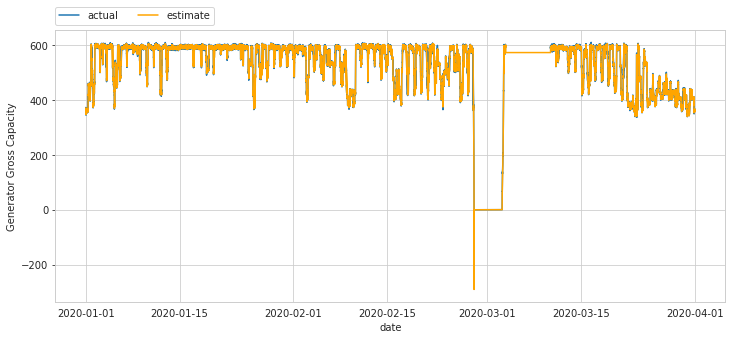

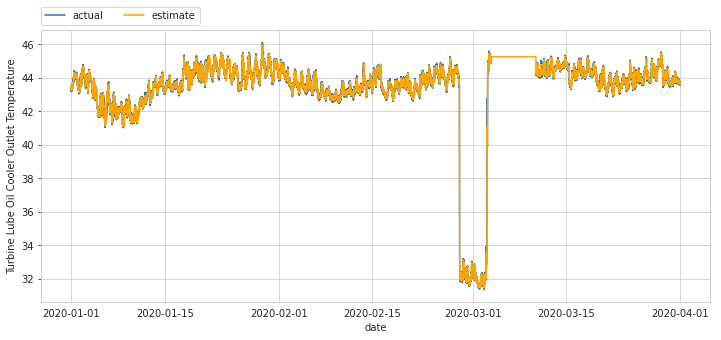

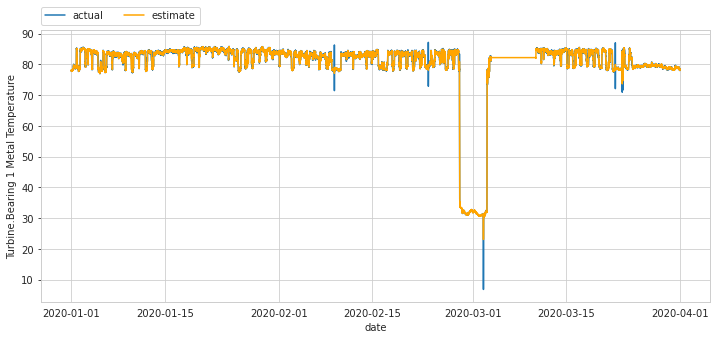

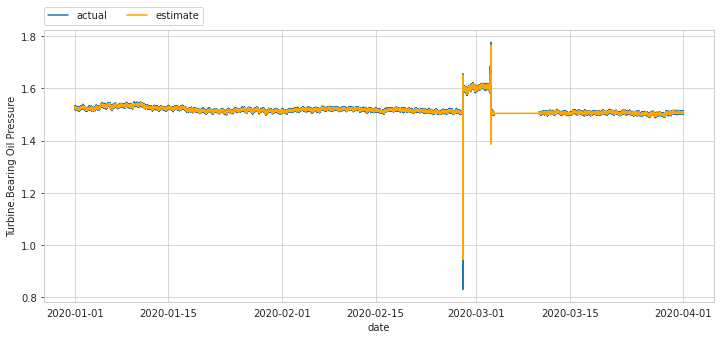

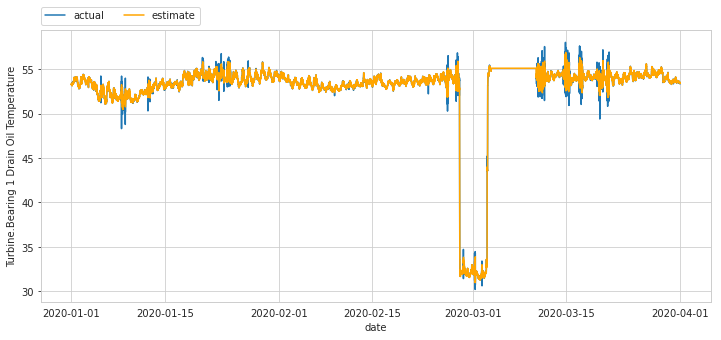

In [49]:
for i,col in enumerate(cols):
    fig, ax1 = plt.subplots(figsize=(12,5))
    ax2 = ax1.twinx()

    ax1.plot(data1['df_actual'].index, data1['df_actual'][col])
    ax1.set_ylabel(col)
    ax1.set_xlabel('date')

    ax1.plot(data1['df_actual'].index, data1['df_estimate'][col], color='orange')
    ax1.set_ylabel(col)
    ax1.set_xlabel('date')
    ax1.legend(['actual','estimate'], bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
               borderaxespad=0, ncol=3)

    ax2.scatter(df_priorities['date'], df_priorities['flag'], color='red', 
                s=40, edgecolors= "black", linewidth=0.5)
    ax2.set_ylabel('Priority', rotation=270, labelpad=20)
    ax2.set_yticks(range(-1,1))
    ax2.get_yaxis().set_visible(False)

    plt.show();

### Data 2

In [50]:
%%time
# loop over time on 'date'
priorities2 = []

for i, date in enumerate(data2['df_actual'].index):
    if i%10000 == 0:
        print(i)
    priority = diagnostic(date, data2)
    priorities2.append(priority)

0


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
CPU times: user 39min 13s, sys: 27.4 s, total: 39min 40s
Wall time: 39min 13s


In [51]:
np.unique(priorities2), len(priorities2)

(array([0]), 175679)

In [52]:
# create dataframe for priority
df_priorities = pd.DataFrame(priorities2, columns=['priority'])
df_priorities['date'] = data2['df_actual'].index

# remove data with priority = 0
df_priorities = df_priorities[df_priorities['priority'] != 0].reset_index(drop=True)
df_priorities['flag'] = 1

In [53]:
# export csv
df_priorities.to_csv('data2_priorities.csv', index=False)

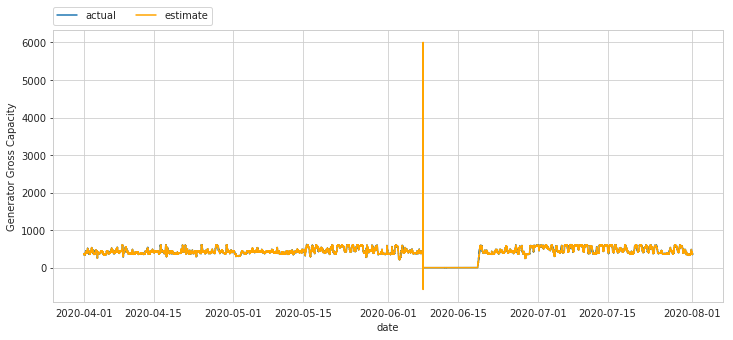

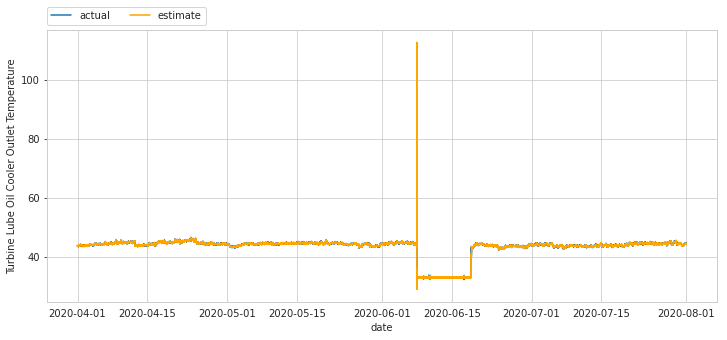

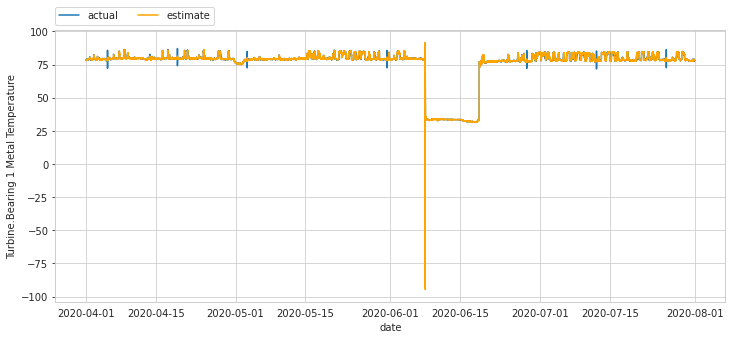

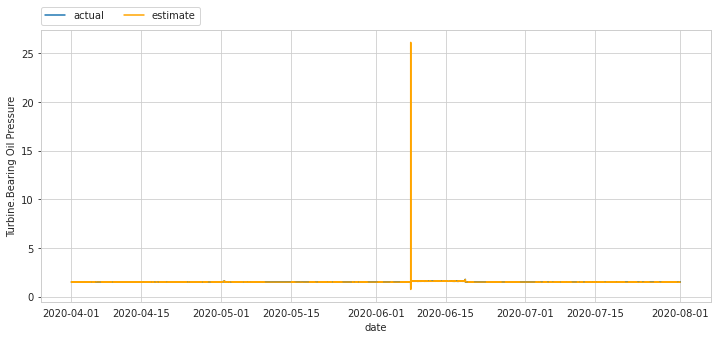

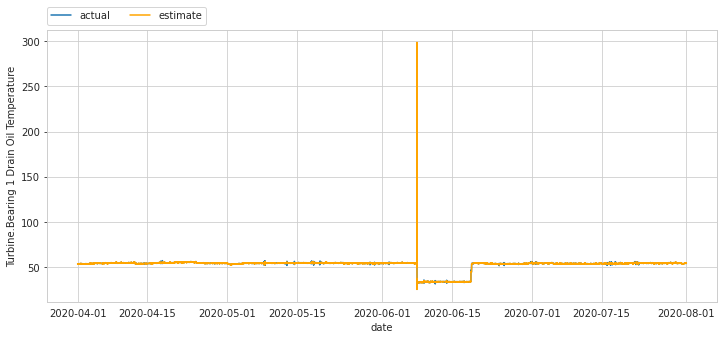

In [54]:
for i,col in enumerate(cols):
    fig, ax1 = plt.subplots(figsize=(12,5))
    ax2 = ax1.twinx()

    ax1.plot(data2['df_actual'].index, data2['df_actual'][col])
    ax1.set_ylabel(col)
    ax1.set_xlabel('date')

    ax1.plot(data2['df_actual'].index, data2['df_estimate'][col], color='orange')
    ax1.set_ylabel(col)
    ax1.set_xlabel('date')
    ax1.legend(['actual','estimate'], bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
               borderaxespad=0, ncol=3)

    ax2.scatter(df_priorities['date'], df_priorities['flag'], color='red', 
                s=40, edgecolors= "black", linewidth=0.5)
    ax2.set_ylabel('Priority', rotation=270, labelpad=20)
    ax2.set_yticks(range(-1,1))
    ax2.get_yaxis().set_visible(False)

    plt.show();

### Data 3

In [55]:
%%time
# loop over time on 'date'
priorities3 = []

for i, date in enumerate(data3['df_actual'].index):
    if i%10000 == 0:
        print(i)
    priority = diagnostic(date, data3)
    priorities3.append(priority)

0


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
CPU times: user 48min 57s, sys: 34.6 s, total: 49min 31s
Wall time: 48min 49s


In [56]:
np.unique(priorities3), len(priorities3)

(array([0]), 220319)

In [57]:
# create dataframe for priority
df_priorities = pd.DataFrame(priorities3, columns=['priority'])
df_priorities['date'] = data3['df_actual'].index

# remove data with priority = 0
df_priorities = df_priorities[df_priorities['priority'] != 0].reset_index(drop=True)
df_priorities['flag'] = 1

In [58]:
# export csv
df_priorities.to_csv('data3_priorities.csv', index=False)

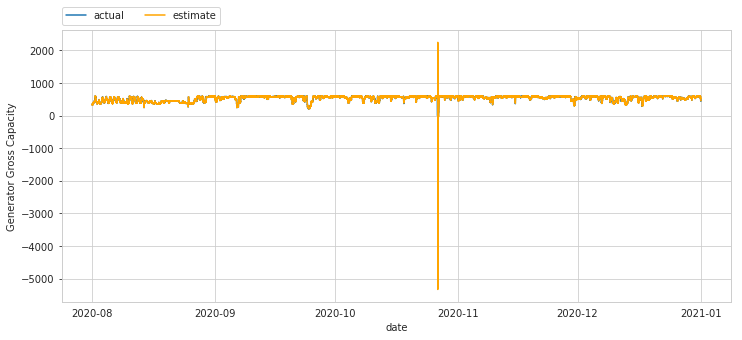

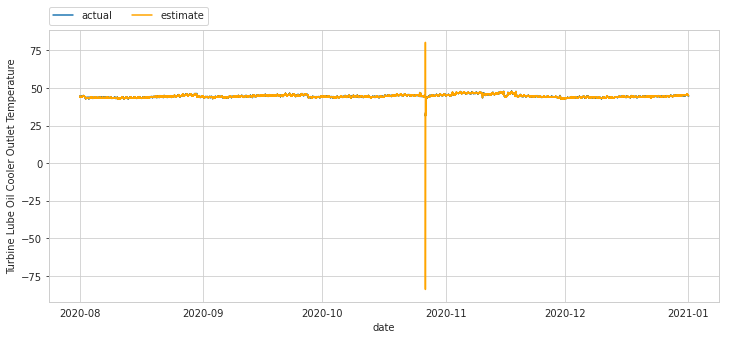

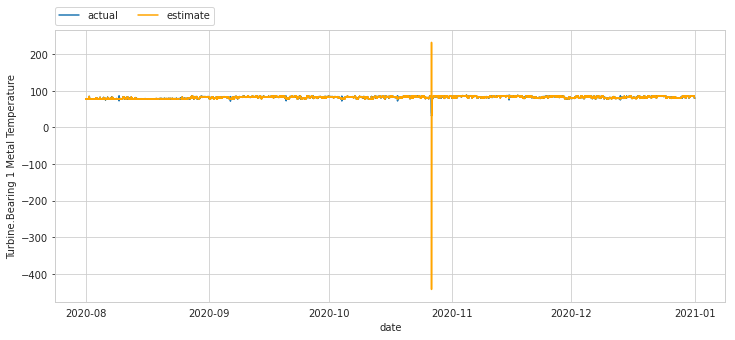

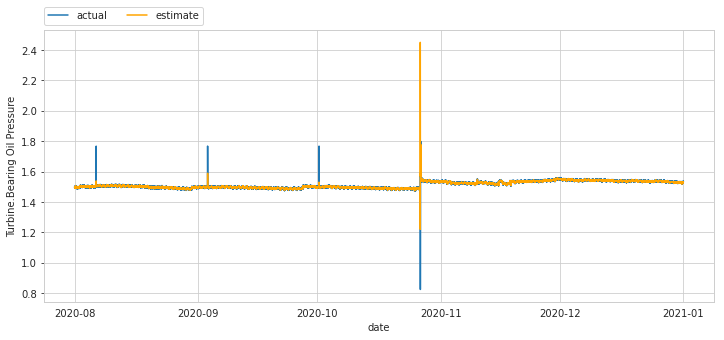

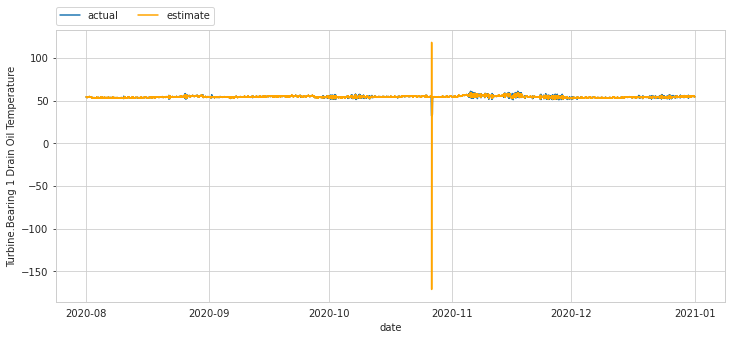

In [59]:
for i,col in enumerate(cols):
    fig, ax1 = plt.subplots(figsize=(12,5))
    ax2 = ax1.twinx()

    ax1.plot(data3['df_actual'].index, data3['df_actual'][col])
    ax1.set_ylabel(col)
    ax1.set_xlabel('date')

    ax1.plot(data3['df_actual'].index, data3['df_estimate'][col], color='orange')
    ax1.set_ylabel(col)
    ax1.set_xlabel('date')
    ax1.legend(['actual','estimate'], bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
               borderaxespad=0, ncol=3)

    ax2.scatter(df_priorities['date'], df_priorities['flag'], color='red', 
                s=40, edgecolors= "black", linewidth=0.5)
    ax2.set_ylabel('Priority', rotation=270, labelpad=20)
    ax2.set_yticks(range(-1,1))
    ax2.get_yaxis().set_visible(False)

    plt.show();

### Data 4

In [60]:
%%time
# loop over time on 'date'
priorities4 = []

for i, date in enumerate(data4['df_actual'].index):
    if i%10000 == 0:
        print(i)
    priority = diagnostic(date, data4)
    priorities4.append(priority)

0


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
CPU times: user 28min 55s, sys: 20.9 s, total: 29min 16s
Wall time: 28min 50s


In [61]:
np.unique(priorities4), len(priorities4)

(array([0]), 129599)

In [62]:
# create dataframe for priority
df_priorities = pd.DataFrame(priorities4, columns=['priority'])
df_priorities['date'] = data4['df_actual'].index

# remove data with priority = 0
df_priorities = df_priorities[df_priorities['priority'] != 0].reset_index(drop=True)
df_priorities['flag'] = 1

In [63]:
# export csv
df_priorities.to_csv('data4_priorities.csv', index=False)

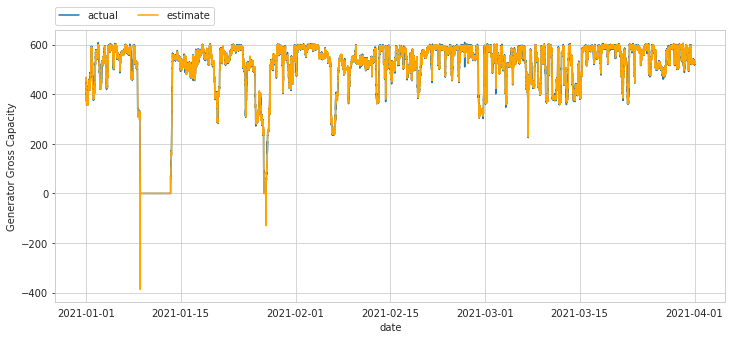

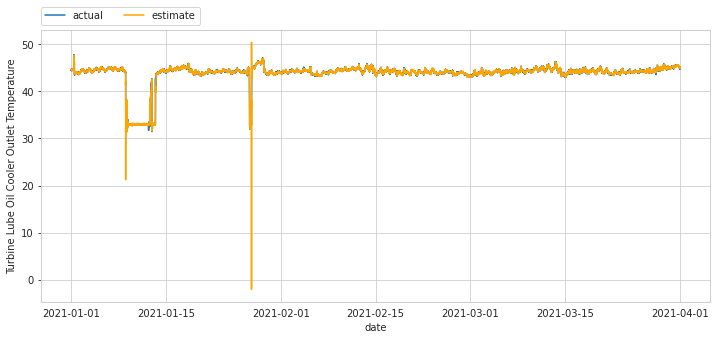

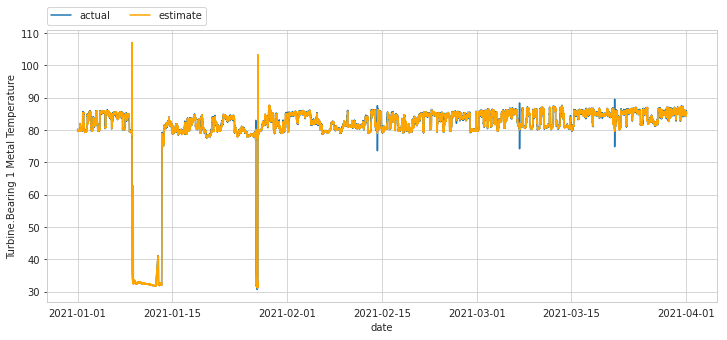

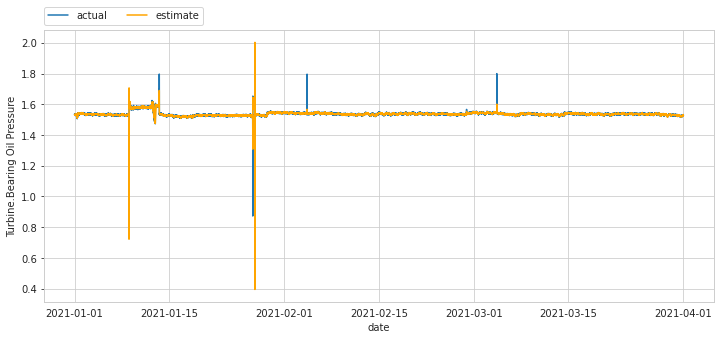

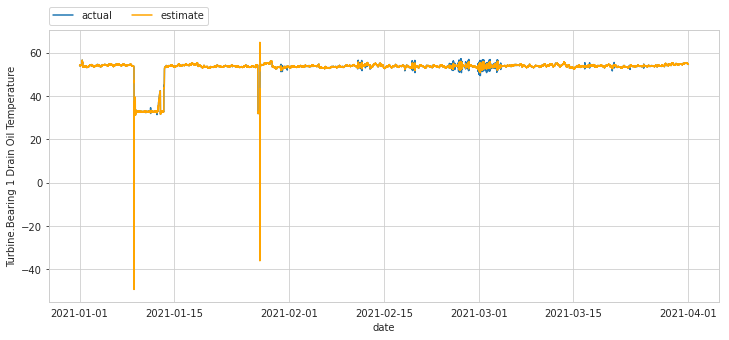

In [64]:
for i,col in enumerate(cols):
    fig, ax1 = plt.subplots(figsize=(12,5))
    ax2 = ax1.twinx()

    ax1.plot(data4['df_actual'].index, data4['df_actual'][col])
    ax1.set_ylabel(col)
    ax1.set_xlabel('date')

    ax1.plot(data4['df_actual'].index, data4['df_estimate'][col], color='orange')
    ax1.set_ylabel(col)
    ax1.set_xlabel('date')
    ax1.legend(['actual','estimate'], bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
               borderaxespad=0, ncol=3)

    ax2.scatter(df_priorities['date'], df_priorities['flag'], color='red', 
                s=40, edgecolors= "black", linewidth=0.5)
    ax2.set_ylabel('Priority', rotation=270, labelpad=20)
    ax2.set_yticks(range(-1,1))
    ax2.get_yaxis().set_visible(False)

    plt.show();

### Data 5

In [65]:
%%time
# loop over time on 'date'
priorities5 = []

for i, date in enumerate(data5['df_actual'].index):
    if i%10000 == 0:
        print(i)
    priority = diagnostic(date, data5)
    priorities5.append(priority)

0


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
CPU times: user 39min 3s, sys: 28.8 s, total: 39min 31s
Wall time: 38min 57s


In [66]:
np.unique(priorities5), len(priorities5)

(array([0]), 175679)

In [67]:
# create dataframe for priority
df_priorities = pd.DataFrame(priorities5, columns=['priority'])
df_priorities['date'] = data5['df_actual'].index

# remove data with priority = 0
df_priorities = df_priorities[df_priorities['priority'] != 0].reset_index(drop=True)
df_priorities['flag'] = 1

In [68]:
# export csv
df_priorities.to_csv('data5_priorities.csv', index=False)

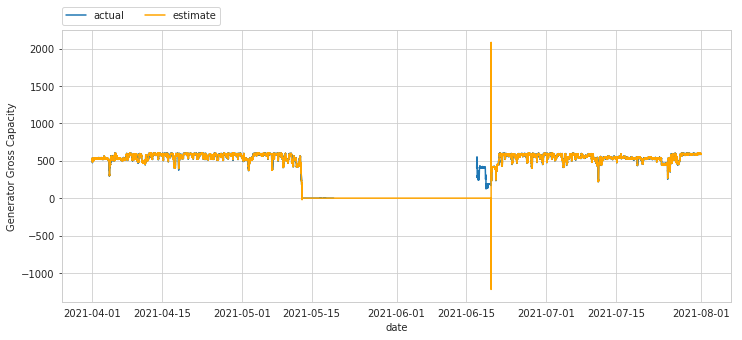

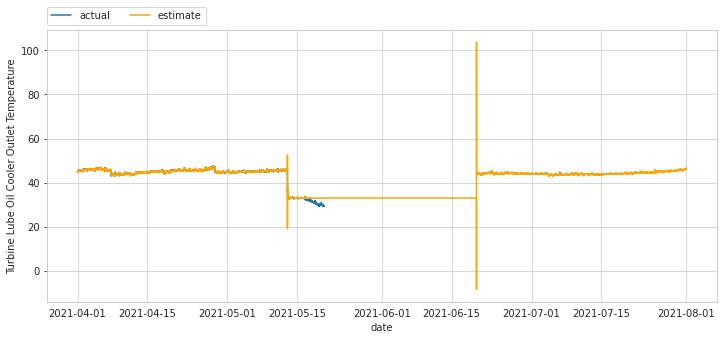

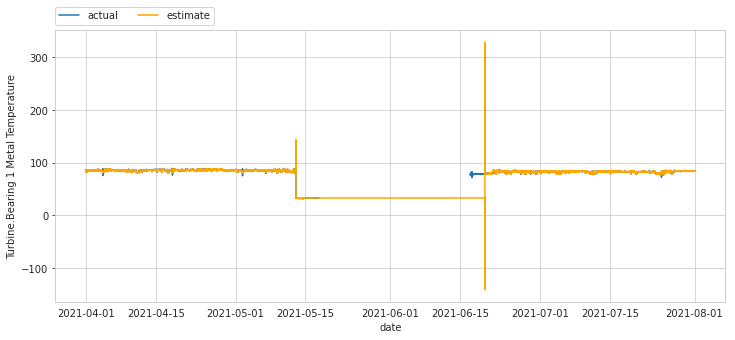

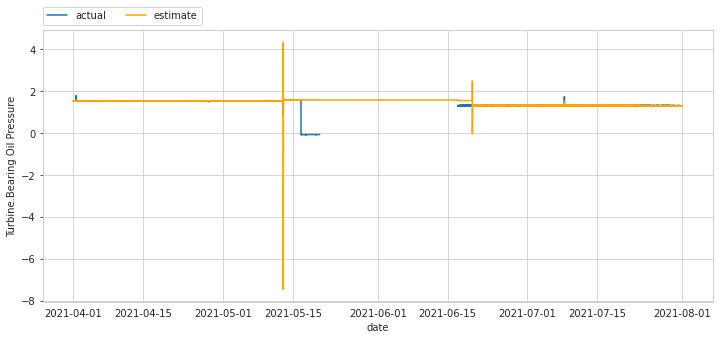

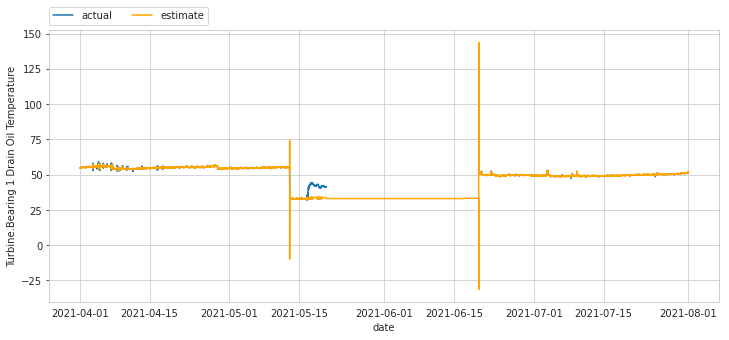

In [69]:
for i,col in enumerate(cols):
    fig, ax1 = plt.subplots(figsize=(12,5))
    ax2 = ax1.twinx()

    ax1.plot(data5['df_actual'].index, data5['df_actual'][col])
    ax1.set_ylabel(col)
    ax1.set_xlabel('date')

    ax1.plot(data5['df_actual'].index, data5['df_estimate'][col], color='orange')
    ax1.set_ylabel(col)
    ax1.set_xlabel('date')
    ax1.legend(['actual','estimate'], bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
               borderaxespad=0, ncol=3)

    ax2.scatter(df_priorities['date'], df_priorities['flag'], color='red', 
                s=40, edgecolors= "black", linewidth=0.5)
    ax2.set_ylabel('Priority', rotation=270, labelpad=20)
    ax2.set_yticks(range(-1,1))
    ax2.get_yaxis().set_visible(False)

    plt.show();

### Data 6

In [70]:
%%time
# loop over time on 'date'
priorities6 = []

for i, date in enumerate(data6['df_actual'].index):
    if i%10000 == 0:
        print(i)
    priority = diagnostic(date, data6)
    priorities6.append(priority)

0


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
CPU times: user 29min 19s, sys: 21.1 s, total: 29min 41s
Wall time: 29min 15s


In [71]:
np.unique(priorities6), len(priorities6)

(array([0]), 132479)

In [72]:
# create dataframe for priority
df_priorities = pd.DataFrame(priorities6, columns=['priority'])
df_priorities['date'] = data6['df_actual'].index

# remove data with priority = 0
df_priorities = df_priorities[df_priorities['priority'] != 0].reset_index(drop=True)
df_priorities['flag'] = 1

In [73]:
# export csv
df_priorities.to_csv('data6_priorities.csv', index=False)

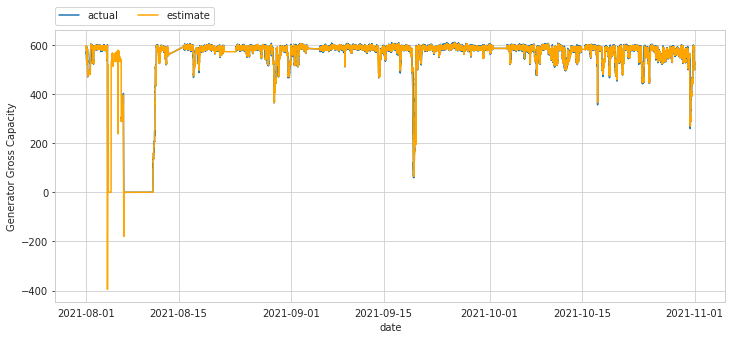

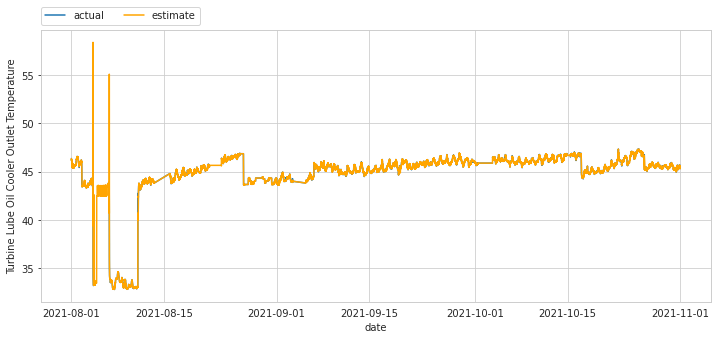

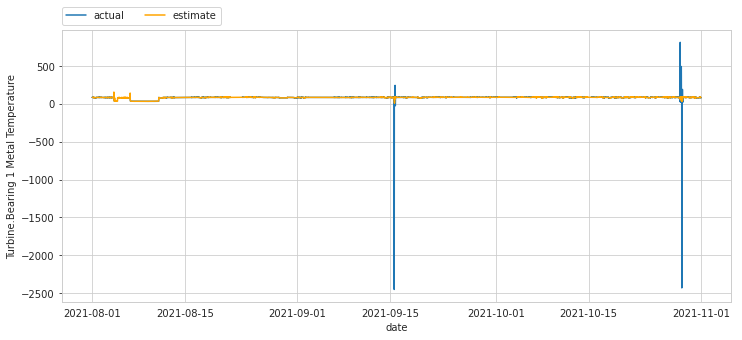

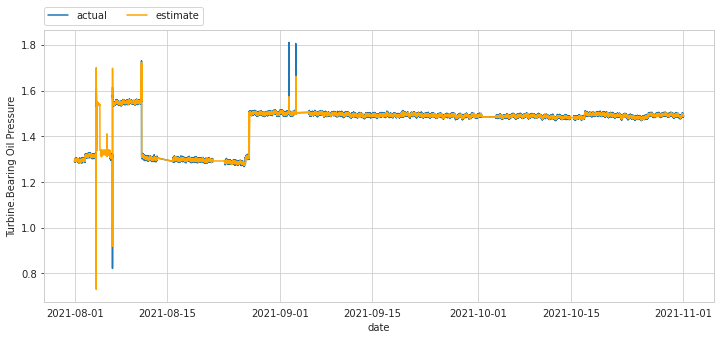

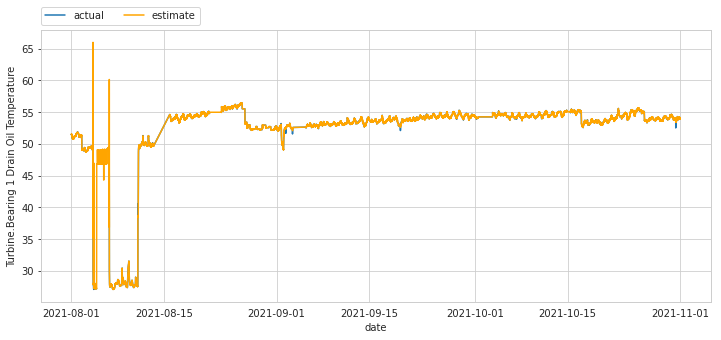

In [74]:
for i,col in enumerate(cols):
    fig, ax1 = plt.subplots(figsize=(12,5))
    ax2 = ax1.twinx()

    ax1.plot(data6['df_actual'].index, data6['df_actual'][col])
    ax1.set_ylabel(col)
    ax1.set_xlabel('date')

    ax1.plot(data6['df_actual'].index, data6['df_estimate'][col], color='orange')
    ax1.set_ylabel(col)
    ax1.set_xlabel('date')
    ax1.legend(['actual','estimate'], bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
               borderaxespad=0, ncol=3)

    ax2.scatter(df_priorities['date'], df_priorities['flag'], color='red', 
                s=40, edgecolors= "black", linewidth=0.5)
    ax2.set_ylabel('Priority', rotation=270, labelpad=20)
    ax2.set_yticks(range(-1,1))
    ax2.get_yaxis().set_visible(False)

    plt.show();